In [1]:
import numpy as np
import pandas as pd
from data_generators.Clinic.Clinic import ClinicGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.inspection import permutation_importance
import umap

In [2]:

def create_gene_dataset_with_disease_effect(
    n_samples: int = 100,
    n_genes: int = 15000,
    num_disease_genes: int = 15000,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_value: float = 1.5,
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset where a specified number of genes
    are correlated with a disease state.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes (int): Number of genes that will show a disease effect.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for disease genes
                                   ("additive_shift" for Microarray, "fold_change" for RNA-Seq).
        disease_effect_value (float or list): Magnitude of the disease effect. Can be a float or a [min, max] range.
        control_disease_ratio (float): The ratio of control to disease patients.
    """
    print(f"Starting gene dataset generation with {n_genes} genes, {num_disease_genes} disease-correlated.")

    # Initialize the ClinicGenerator
    generator = ClinicGenerator(seed=42)

    # Generate demographic data to get the groups
    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # Define the disease effect using the new configuration object
    disease_effects_config = [
        {
            'name': 'disease_effect',
            'indices': list(range(num_disease_genes)),
            'effect_type': disease_effect_type,
            'effect_value': disease_effect_value
        }
    ]

    # Generate gene data using the new config
    df_genes = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        disease_effects_config=disease_effects_config
    )

    # Add the 'Grupo' column to the dataframe
    df_genes['Grupo'] = demographic_df['Grupo']

    # Convert 'Grupo' column to binary (0 for Control, 1 for Enfermedad)
    df_genes['Grupo'] = df_genes['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes

In [3]:
def create_minimal_effect_gene_dataset(
    n_samples: int = 100,
    n_genes: int = 15000,
    num_disease_genes: int = 10,
    num_correlated_genes: int = 10,
    correlation_value: float = 0.8,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_value: float = 0.0, # Minimal effect
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset where a subset of genes are correlated with each other,
    and a subset of genes have a minimal correlation with a disease state.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes (int): Number of genes that will show a disease effect.
        num_correlated_genes (int): Number of genes in the correlated group.
        correlation_value (float): Correlation value for genes within the group.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for disease genes
                                   ("additive_shift" for Microarray, "fold_change" for RNA-Seq).
        disease_effect_value (float or list): Magnitude of the disease effect. Can be a float or a [min, max] range.
    """
    print(f"Starting gene dataset generation with {n_genes} genes...")

    # Initialize the ClinicGenerator
    generator = ClinicGenerator(seed=42)

    # Generate demographic data to get the groups
    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # --- 1. Define correlation matrix ---
    correlation_matrix = np.identity(n_genes)
    if num_correlated_genes > 0 and correlation_value != 0:
        print(f"Introducing correlation for a group of {num_correlated_genes} genes.")
        corr_block = np.full((num_correlated_genes, num_correlated_genes), correlation_value)
        np.fill_diagonal(corr_block, 1.0)
        # Place the block at the beginning of the matrix
        correlation_matrix[0:num_correlated_genes, 0:num_correlated_genes] = corr_block

    # Define the disease effect using the new configuration object
    disease_effects_config = [
        {
            'name': 'disease_effect',
            'indices': list(range(num_disease_genes)),
            'effect_type': disease_effect_type,
            'effect_value': disease_effect_value
        }
    ]

    # Generate gene data
    df_genes = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        gene_correlations=correlation_matrix,
        disease_effects_config=disease_effects_config
    )

    # Add the 'Grupo' column to the dataframe
    df_genes['Grupo'] = demographic_df['Grupo']

    # Convert 'Grupo' column to binary (0 for Control, 1 for Enfermedad)
    df_genes['Grupo'] = df_genes['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes

In [4]:
def create_split_gene_correlated_dataset(
    n_samples: int = 100,
    n_genes: int = 50,
    num_disease_genes_1: int = 20,
    num_disease_genes_2: int = 10,
    corr_group_1: float = 0.6,
    corr_group_2: float = 0.7,
    gene_type: str = "Microarray",
    disease_effect_type: str = "additive_shift",
    disease_effect_type_2: str = None, 
    disease_effect_value: float = 1.5,
    disease_effect_value_2: float = None, 
    num_patients_subtype_1: int = 20, # New: Number of patients in the first disease subtype
    control_disease_ratio: float = 0.5
):
    """
    Generates a gene expression dataset with two independent, correlated gene modules.
    It now supports creating disease subtypes, where different subsets of disease patients
    have different molecular effects.

    Args:
        n_samples (int): Number of patient samples to generate.
        n_genes (int): Total number of genes in the dataset.
        num_disease_genes_1 (int): Number of genes in the first group.
        num_disease_genes_2 (int): Number of genes in the second group.
        corr_group_1 (float): Correlation value for genes within the first group.
        corr_group_2 (float): Correlation value for genes within the second group.
        gene_type (str): Type of gene data to generate ("Microarray" or "RNA-Seq").
        disease_effect_type (str): Type of effect for the first group of disease genes.
        disease_effect_type_2 (str, optional): Type of effect for the second group. Defaults to `disease_effect_type`.
        disease_effect_value (float or list): Magnitude of the disease effect for the first group.
        disease_effect_value_2 (float or list, optional): Magnitude of the disease effect for the second group.
        num_patients_subtype_1 (int): Number of disease patients to assign to the first subtype (affecting module 1).
    """
    total_affected_genes = num_disease_genes_1 + num_disease_genes_2
    if total_affected_genes > n_genes:
        raise ValueError("The sum of disease genes cannot be greater than the total number of genes.")

    # Default for second effect type is the same as the first
    if disease_effect_type_2 is None:
        disease_effect_type_2 = disease_effect_type

    if disease_effect_value_2 is None:
        if isinstance(disease_effect_value, list):
            if disease_effect_type_2 == 'fold_change':
                 disease_effect_value_2 = [1/x for x in reversed(disease_effect_value)]
            else:
                 disease_effect_value_2 = [-x for x in reversed(disease_effect_value)]
        else:
            if disease_effect_type_2 == 'fold_change':
                disease_effect_value_2 = 1 / disease_effect_value if disease_effect_value != 0 else 1
            else:
                disease_effect_value_2 = -disease_effect_value

    print(f"Starting gene dataset generation with {n_genes} genes...")

    generator = ClinicGenerator(seed=42)

    demographic_df, raw_demographic_data = generator.generate_demographic_data(
        n_samples=n_samples,
        control_disease_ratio=control_disease_ratio
    )

    # --- 1. Define Gene Modules and Block-Diagonal Correlation Matrix ---
    module_1_indices = list(range(num_disease_genes_1))
    module_2_start_index = num_disease_genes_1
    module_2_indices = list(range(module_2_start_index, module_2_start_index + num_disease_genes_2))

    correlation_matrix = np.identity(n_genes)

    def fill_block(matrix, indices, corr_value):
        for i in indices:
            for j in indices:
                if i != j:
                    matrix[i, j] = corr_value

    if num_disease_genes_1 > 0:
        fill_block(correlation_matrix, module_1_indices, corr_group_1)

    if num_disease_genes_2 > 0:
        fill_block(correlation_matrix, module_2_indices, corr_group_2)

    # --- 2. Define Disease Heterogeneity (Subtypes and Effects) ---
    print(f"Defining disease subtypes: {num_patients_subtype_1} patients for module 1, remainder for module 2.")
    disease_effects_config = {
        'patient_subgroups': [
            {
                'name': 'Subtype_A',
                'count': num_patients_subtype_1,
                'apply_effects': ['module_1_effect']
            },
            {
                'name': 'Subtype_B',
                'remainder': True,
                'apply_effects': ['module_2_effect']
            }
        ],
        'effects': {
            'module_1_effect': {
                'indices': module_1_indices,
                'effect_type': disease_effect_type,
                'effect_value': disease_effect_value
            },
            'module_2_effect': {
                'indices': module_2_indices,
                'effect_type': disease_effect_type_2,
                'effect_value': disease_effect_value_2
            }
        }
    }

    # --- 3. Generate all gene data in a single call ---
    print("Generating gene data with disease subtypes...")
    df_genes_final = generator.generate_gene_data(
        n_genes=n_genes,
        gene_type=gene_type,
        demographic_df=demographic_df,
        demographic_id_col=demographic_df.index.name,
        raw_demographic_data=raw_demographic_data,
        gene_correlations=correlation_matrix,
        disease_effects_config=disease_effects_config,
        n_samples=n_samples
    )

    df_genes_final['Grupo'] = demographic_df['Grupo']
    df_genes_final['Grupo'] = df_genes_final['Grupo'].map({'Control': 0, 'Enfermedad': 1})

    print("Generation complete.")
    return df_genes_final

In [5]:
# --- Configuración Visual ---
# Puedes ajustar cuántos "top features" mostrar en los gráficos
N_TOP_FEATURES_TO_SHOW = 20


def train_and_evaluate(df, dataset_name):
    """
    Trains and evaluates a model for a given dataset, calculating 
    the average inter-gene correlation, feature importance, and
    displaying a heatmap of the correlation matrix for the top features.
    """
    print(f"\n{'='*50}")
    print(f"Processing dataset: {dataset_name}")
    print(f"{'='*50}")
    
    try:
        # Clean up index column if present
        df_clean = df.drop(columns=['Unnamed: 0'], errors='ignore')

        # Assume the last column ('Grupo' or similar) is the target variable
        X = df_clean.iloc[:, :-1]
        y = df_clean.iloc[:, -1]
        
        # --- 1. Global Correlation Analysis ---
        print("\n[1] Global Correlation Analysis")
        # Calculate the absolute correlation matrix for all genes (features)
        corr_matrix_full = X.corr() # <-- Quitamos .abs() para ver correl. negativas en el heatmap

        # Print class distribution
        print("\n[2] Model Training & Evaluation")
        print("Class distribution:")
        print(y.value_counts())

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

        # Initialize and train the model
        model = RandomForestClassifier(random_state=42)
        print("Training model...")
        model.fit(X_train, y_train)

        # Make predictions and evaluate the model
        print("Evaluating model...")
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        # --- CORRECCIÓN: 'average' debe ser 'binary' o 'macro' para P/R en multiclase ---
        # Asumiendo binario o promediado 'macro' si hay >2 clases
        avg_method = 'binary' if len(y.unique()) == 2 else 'macro'
        precision = precision_score(y_test, predictions, average=avg_method, zero_division=0)
        recall = recall_score(y_test, predictions, average=avg_method, zero_division=0)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision ({avg_method}): {precision:.4f}")
        print(f"Recall ({avg_method}): {recall:.4f}")
        
        # --- 3. Feature Importance (MEJORADO VISUALMENTE) ---
        print("\n[3] Feature Importance")
        
        # Extract feature importance and create a Series indexed by gene names
        feature_importances = pd.Series(
            model.feature_importances_, 
            index=X.columns
        ).sort_values(ascending=False)
        
        # Determinar el número real de features a mostrar
        n_features_actual = min(N_TOP_FEATURES_TO_SHOW, len(feature_importances))
        
        # --- 3a. Resumen en Consola ---
        print(f"\n[3a] Top {n_features_actual} Most Important Features (Consola):")
        print(feature_importances.head(n_features_actual).to_string())
        
        # --- 3b. NUEVO: Gráfico de Barras de Importancia ---
        print(f"\n[3b] Generating Feature Importance plot (Top {n_features_actual})...")
        
        # Preparar datos para el gráfico (ascendente para barh)
        top_features_df = feature_importances.sort_values(ascending=True)

        plt.figure(figsize=(12, 8))
        plt.barh(
            top_features_df.index,
            top_features_df.values,
            align='center', alpha=0.8
        )
        plt.title(f'Top {n_features_actual} Most Important Features (Gini Importance)\n{dataset_name}', fontsize=16)
        plt.xlabel('Importance Score', fontsize=12)
        plt.ylabel('Feature (Gene)', fontsize=12)
        plt.margins(y=0.01)
        plt.grid(True, linestyle='--', alpha=0.5, axis='x')
        plt.tight_layout()
        
        print("Displaying Feature Importance plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 4. Heatmap Generation (CORREGIDO: Solo Top Features) ---
        print(f"\n[4] Generating Correlation Heatmap for Top {n_features_actual} Features...")
        
        # Obtener los nombres de los features más importantes
        top_feature_names = feature_importances.head(n_features_actual).index.tolist()
        
        # Filtrar la matriz de correlación para incluir solo los top features
        corr_matrix_top = corr_matrix_full.loc[top_feature_names, top_feature_names]
        
        # Ajustar tamaño de figura (más pequeño y legible)
        fig_size = max(10, n_features_actual * 0.6)
        plt.figure(figsize=(40, 20))
        
        g = sns.heatmap(
            corr_matrix_full, # 
            annot=True, 
            fmt=".2f", 
            cmap='vlag', # 'vlag' o 'coolwarm' son buenas para correlación
            linewidths=.5,
            linecolor='black',
            center=0,      # <-- Centrar en 0 para correlación
            cbar_kws={'label': 'Correlation Coefficient'}
        )
        g.set_title(f'Correlation Heatmap (Top {n_features_actual} Features)\n{dataset_name}', fontsize=12)
        plt.xticks(rotation=90, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        print("Displaying Top Features Heatmap plot (cierre la ventana para continuar)...")
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {dataset_name}: {e}")

In [6]:
# Generate the datasets
df_gene = create_gene_dataset_with_disease_effect(
    n_samples=100, # Number of patients
    n_genes=50,
    num_disease_genes=50, # Half of the genes correlated with disease
    gene_type="Microarray", # Or "RNA-Seq"
    disease_effect_type="additive_shift", # "additive_shift" for Microarray, "fold_change" for RNA-Seq
    disease_effect_value=[8, 10], # Use a range for a uniform stochastic effect
)

df_minimal = create_minimal_effect_gene_dataset(
    n_samples=100,
    n_genes=50,
    num_disease_genes=10,
    num_correlated_genes=10,
    correlation_value=0.8,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_value=[0.05, 0.15], # Use a range for a minimal, uniform stochastic effect
)

df_split = create_split_gene_correlated_dataset(
    n_samples=100,
    n_genes=50,
    num_disease_genes_1=20,
    num_disease_genes_2=10,
    corr_group_1=0.6,
    corr_group_2=0.7,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_type_2="additive_shift",
    disease_effect_value=[10, 12],
    disease_effect_value_2=[6, 8],
    num_patients_subtype_1 = 25,
)

Starting gene dataset generation with 50 genes, 50 disease-correlated.
Generation complete.
Starting gene dataset generation with 50 genes...
Introducing correlation for a group of 10 genes.
Generation complete.
Starting gene dataset generation with 50 genes...
Defining disease subtypes: 25 patients for module 1, remainder for module 2.
Generating gene data with disease subtypes...
Generation complete.



Processing dataset: Gene Dataset with Disease Effect

[1] Global Correlation Analysis

[2] Model Training & Evaluation
Class distribution:
Grupo
1    50
0    50
Name: count, dtype: int64
Training model...
Evaluating model...
Accuracy: 1.0000
Precision (binary): 1.0000
Recall (binary): 1.0000

[3] Feature Importance

[3a] Top 20 Most Important Features (Consola):
G_40    0.07
G_26    0.06
G_3     0.05
G_24    0.04
G_1     0.04
G_15    0.04
G_34    0.03
G_27    0.03
G_28    0.03
G_29    0.03
G_32    0.03
G_37    0.03
G_41    0.03
G_6     0.03
G_44    0.03
G_21    0.02
G_31    0.02
G_39    0.02
G_43    0.02
G_48    0.02

[3b] Generating Feature Importance plot (Top 20)...
Displaying Feature Importance plot (cierre la ventana para continuar)...


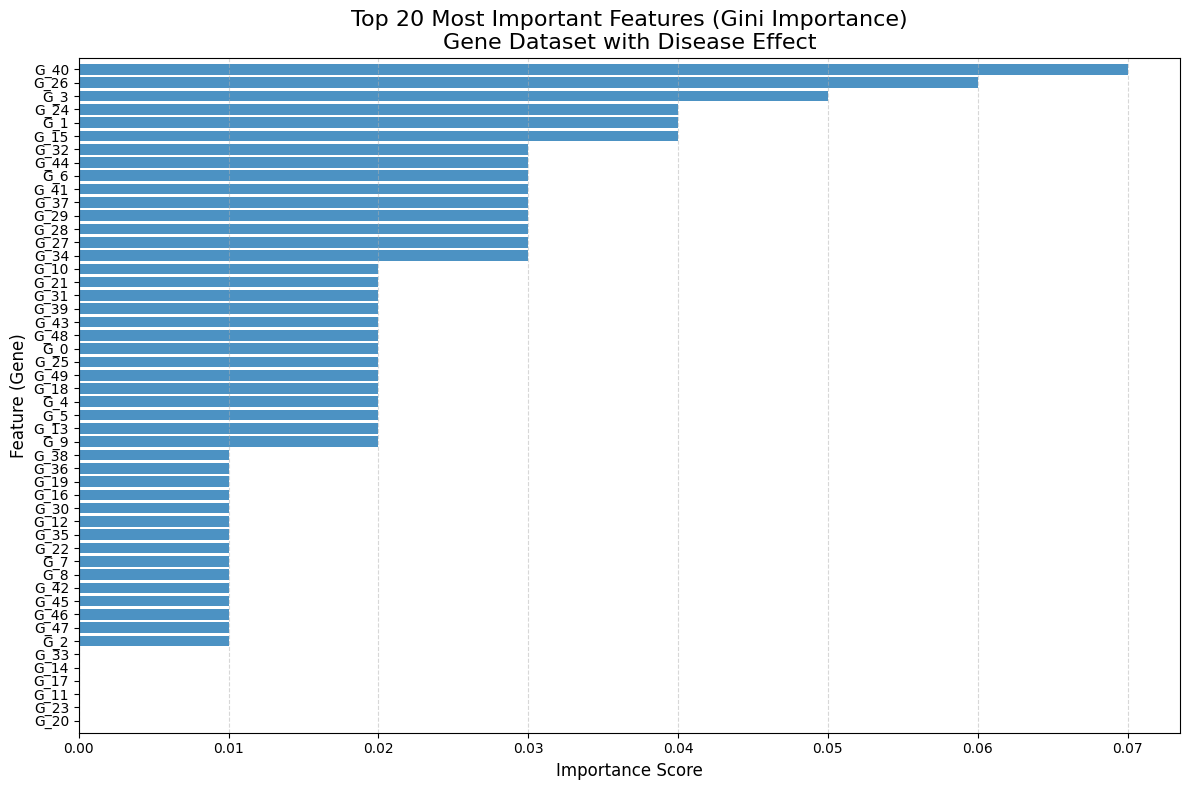


[4] Generating Correlation Heatmap for Top 20 Features...


Displaying Top Features Heatmap plot (cierre la ventana para continuar)...


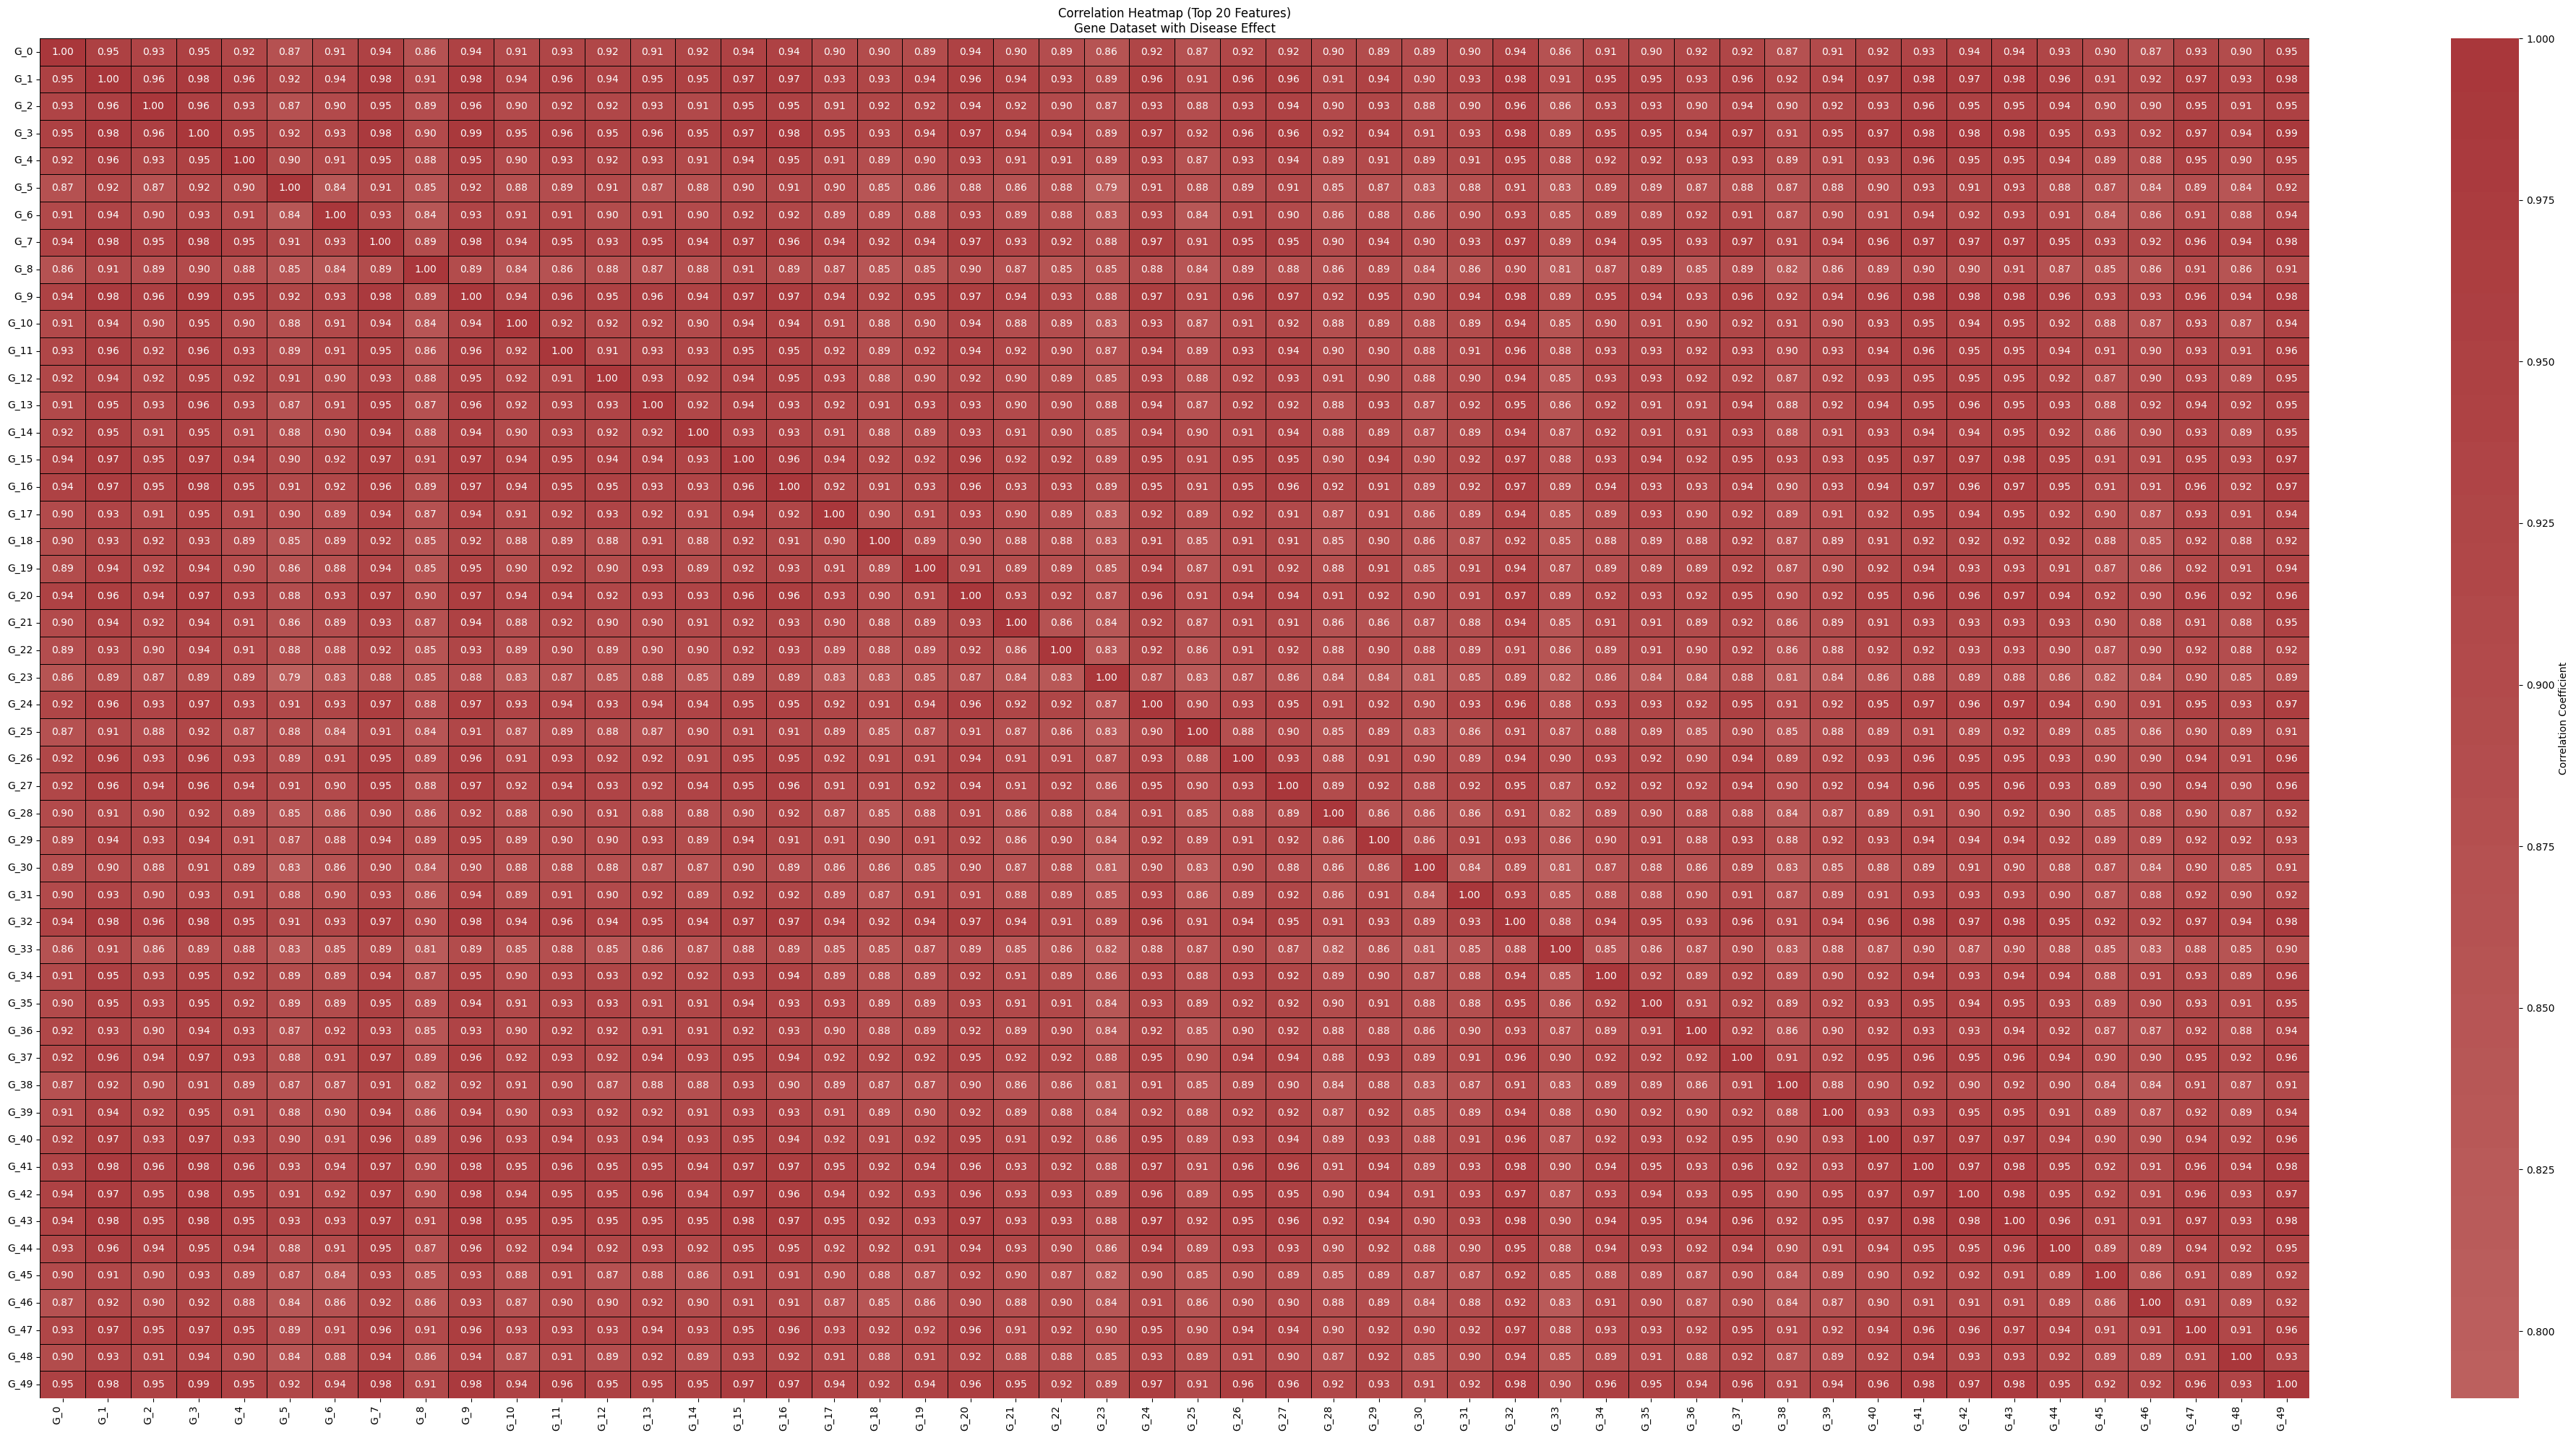


Processing dataset: Minimal Effect Gene Dataset

[1] Global Correlation Analysis

[2] Model Training & Evaluation
Class distribution:
Grupo
1    50
0    50
Name: count, dtype: int64
Training model...
Evaluating model...
Accuracy: 0.6000
Precision (binary): 0.6000
Recall (binary): 0.6000

[3] Feature Importance

[3a] Top 20 Most Important Features (Consola):
G_12    0.067610
G_28    0.041425
G_39    0.037276
G_26    0.035069
G_30    0.034097
G_40    0.032355
G_6     0.029857
G_19    0.028216
G_27    0.028197
G_25    0.027579
G_34    0.026174
G_29    0.024697
G_21    0.024424
G_46    0.024052
G_32    0.022598
G_42    0.021028
G_33    0.021025
G_43    0.020891
G_45    0.020620
G_13    0.020000

[3b] Generating Feature Importance plot (Top 20)...
Displaying Feature Importance plot (cierre la ventana para continuar)...


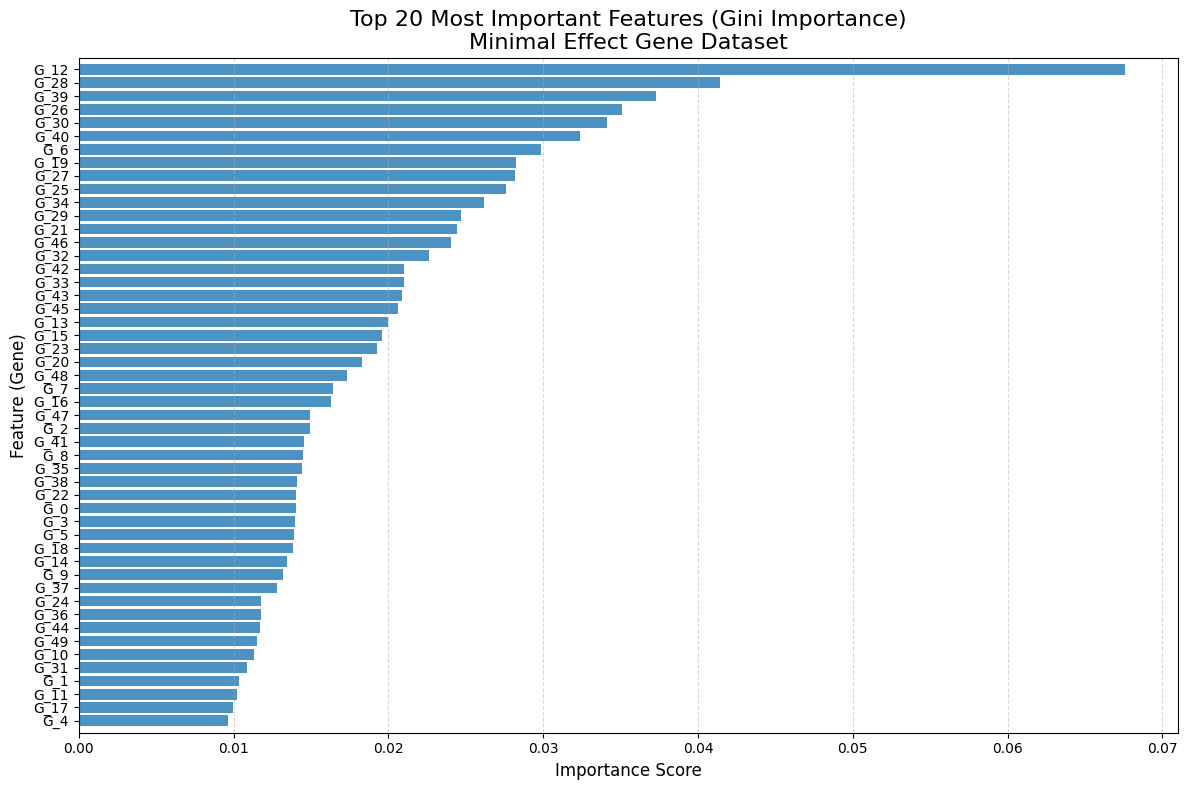


[4] Generating Correlation Heatmap for Top 20 Features...
Displaying Top Features Heatmap plot (cierre la ventana para continuar)...


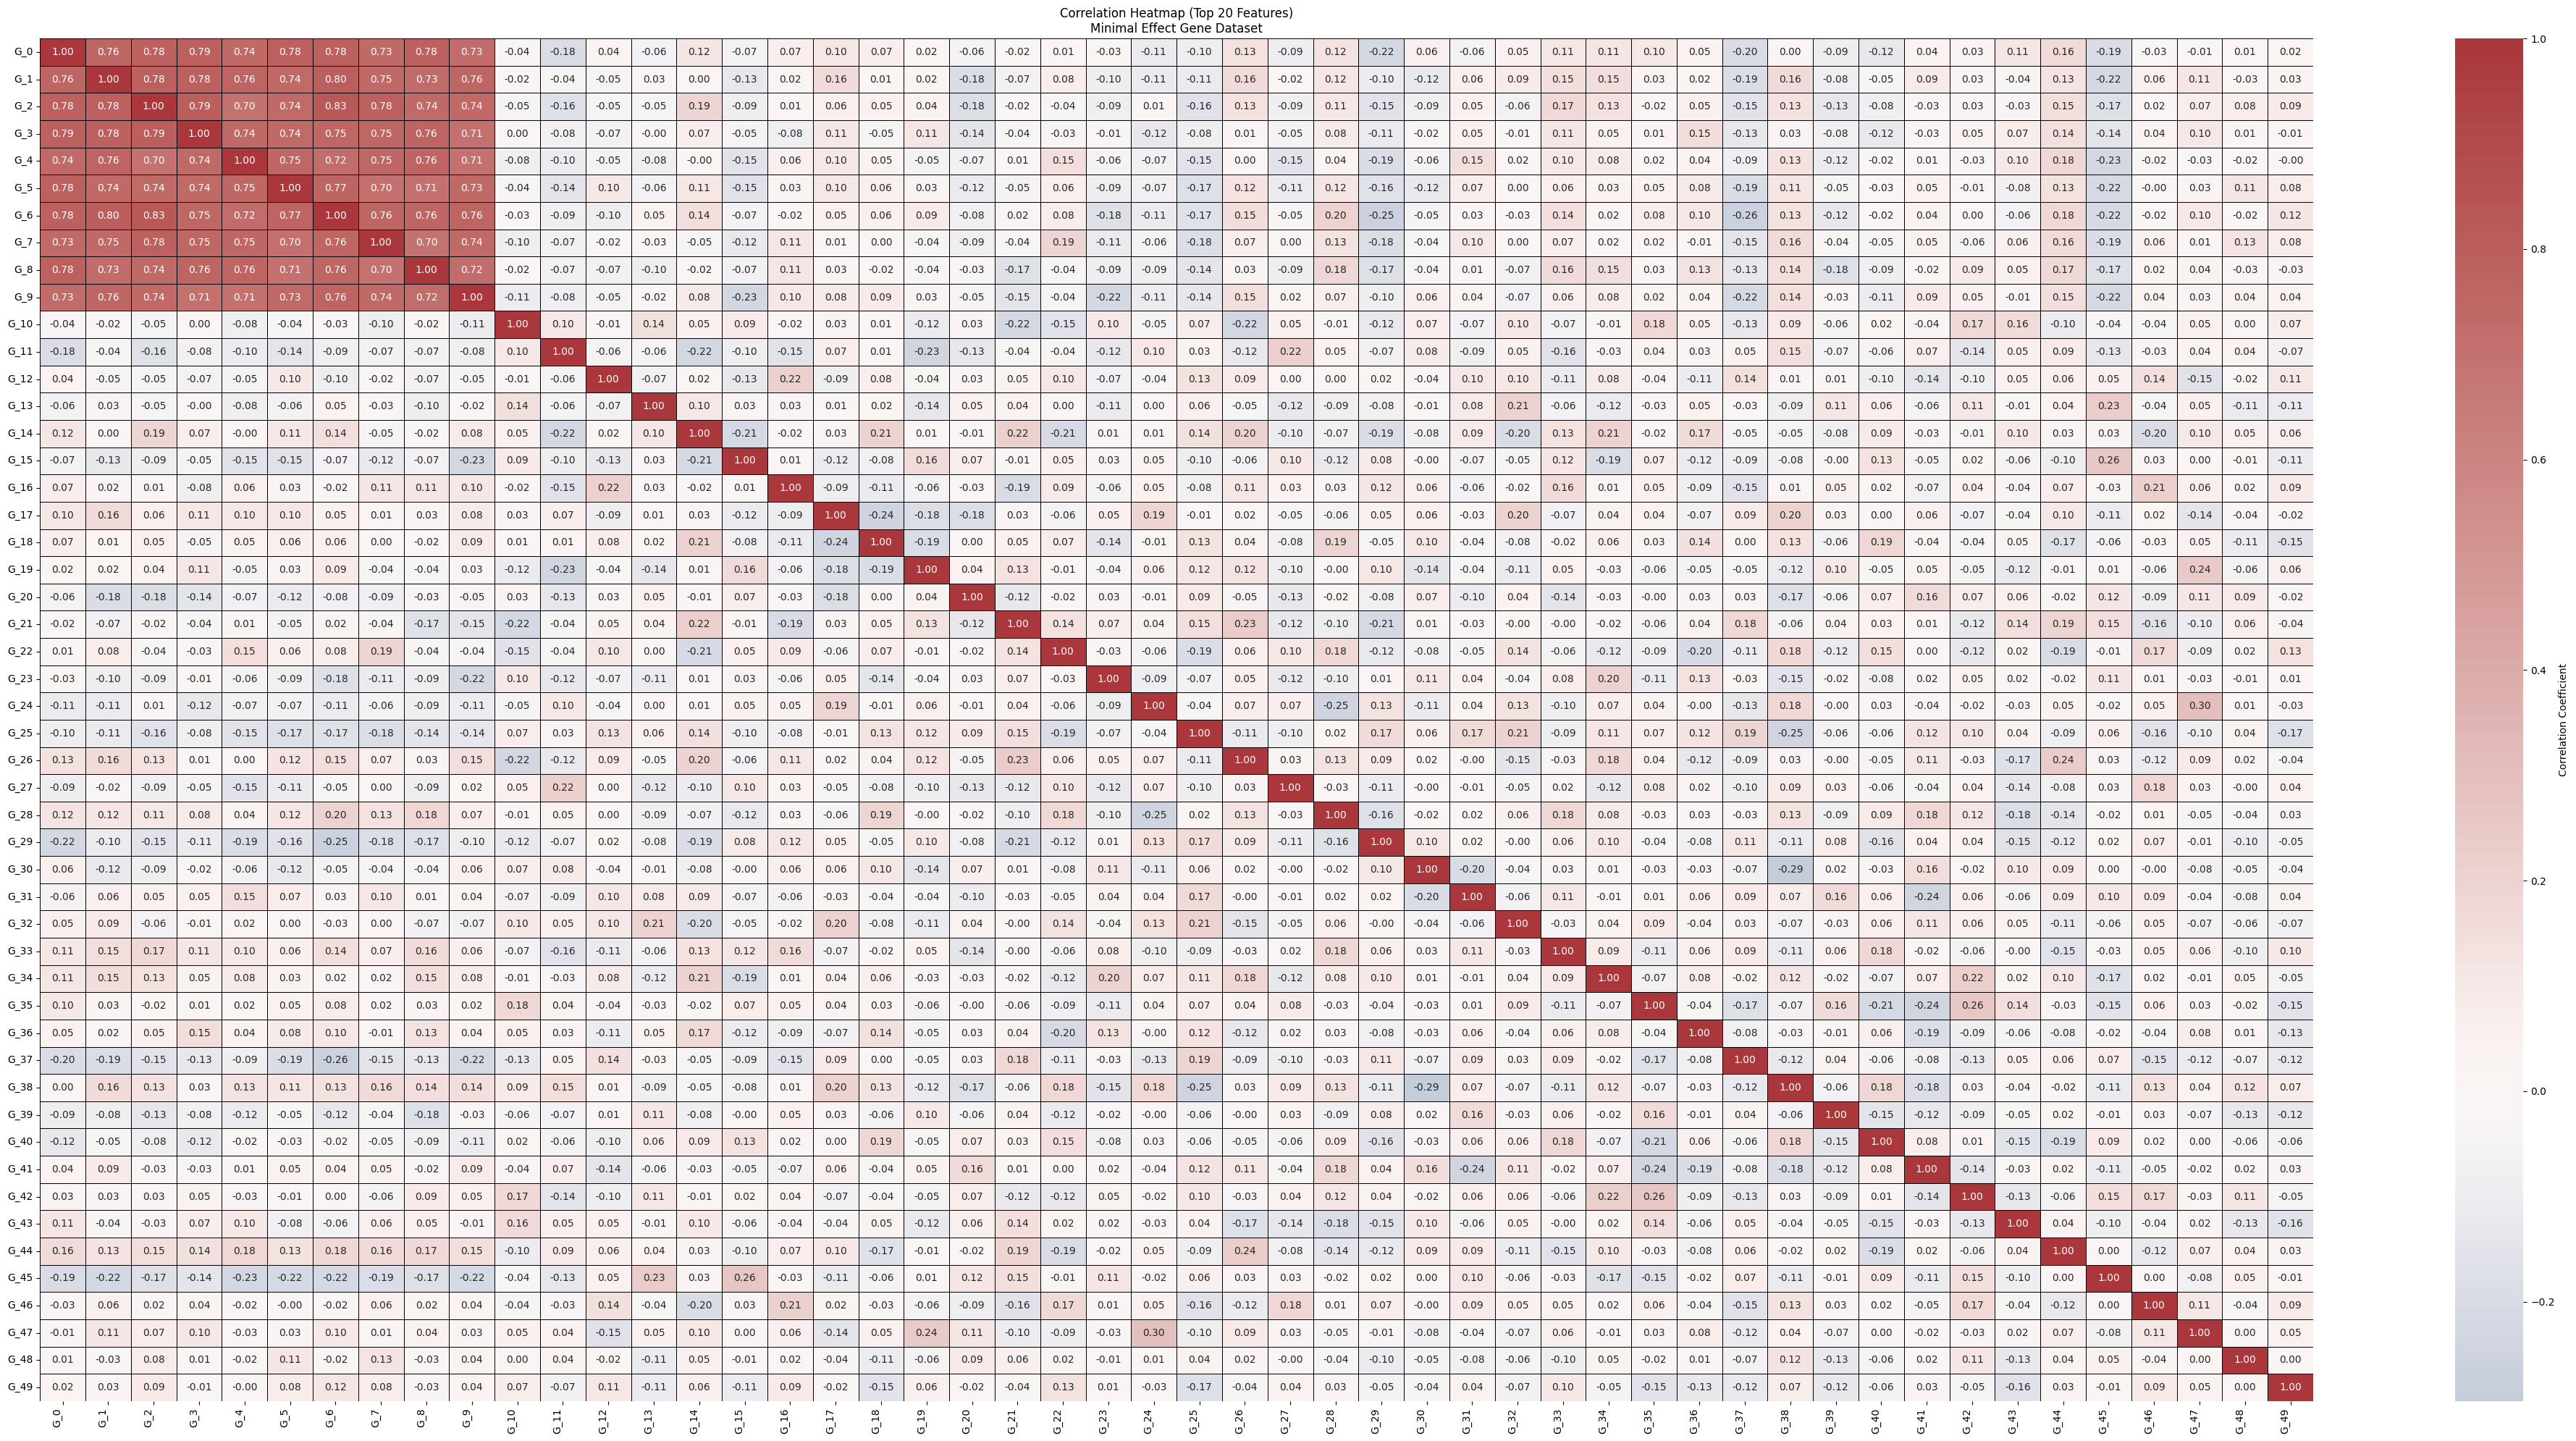


Processing dataset: Split Gene Correlated Dataset

[1] Global Correlation Analysis

[2] Model Training & Evaluation
Class distribution:
Grupo
1    50
0    50
Name: count, dtype: int64
Training model...
Evaluating model...
Accuracy: 1.0000
Precision (binary): 1.0000
Recall (binary): 1.0000

[3] Feature Importance

[3a] Top 20 Most Important Features (Consola):
G_25    0.083724
G_7     0.059660
G_20    0.056935
G_24    0.049819
G_21    0.049084
G_28    0.048890
G_29    0.048166
G_27    0.048148
G_1     0.042509
G_26    0.042258
G_4     0.040472
G_3     0.036256
G_16    0.033491
G_22    0.032553
G_23    0.032415
G_0     0.031171
G_10    0.029826
G_12    0.026272
G_14    0.024781
G_8     0.022464

[3b] Generating Feature Importance plot (Top 20)...
Displaying Feature Importance plot (cierre la ventana para continuar)...


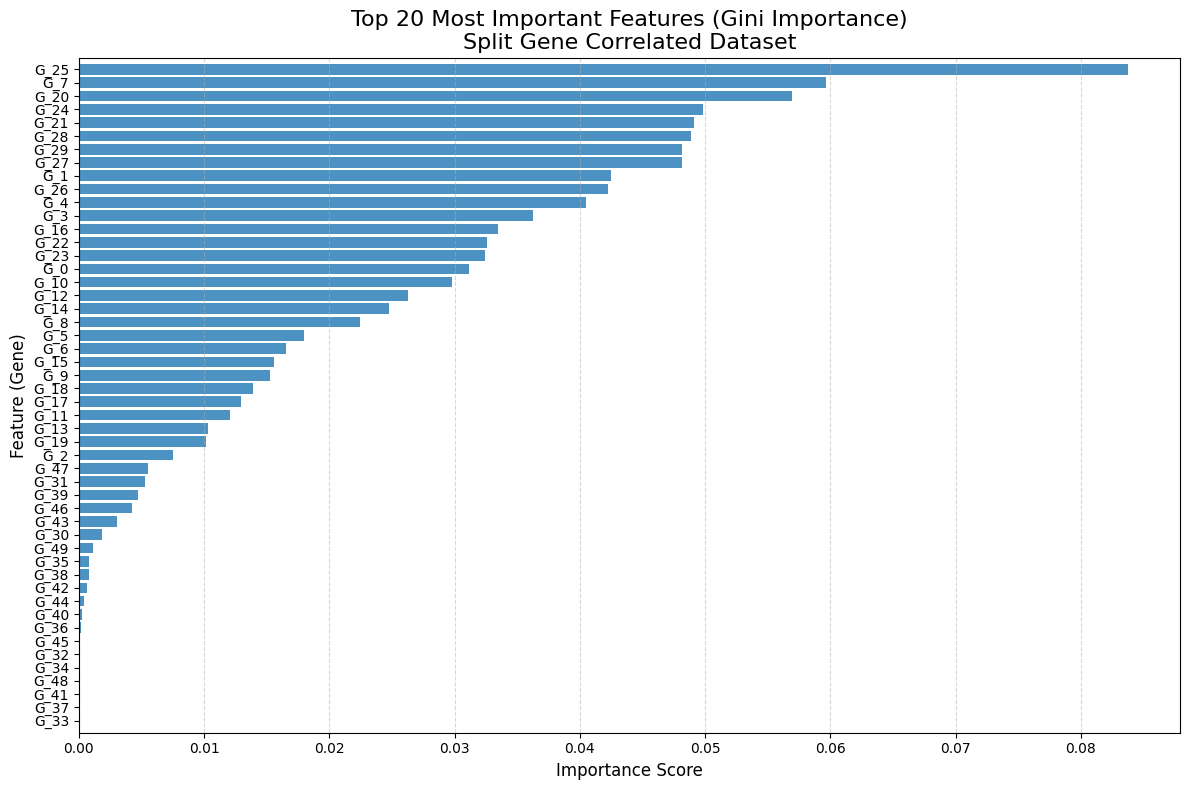


[4] Generating Correlation Heatmap for Top 20 Features...
Displaying Top Features Heatmap plot (cierre la ventana para continuar)...


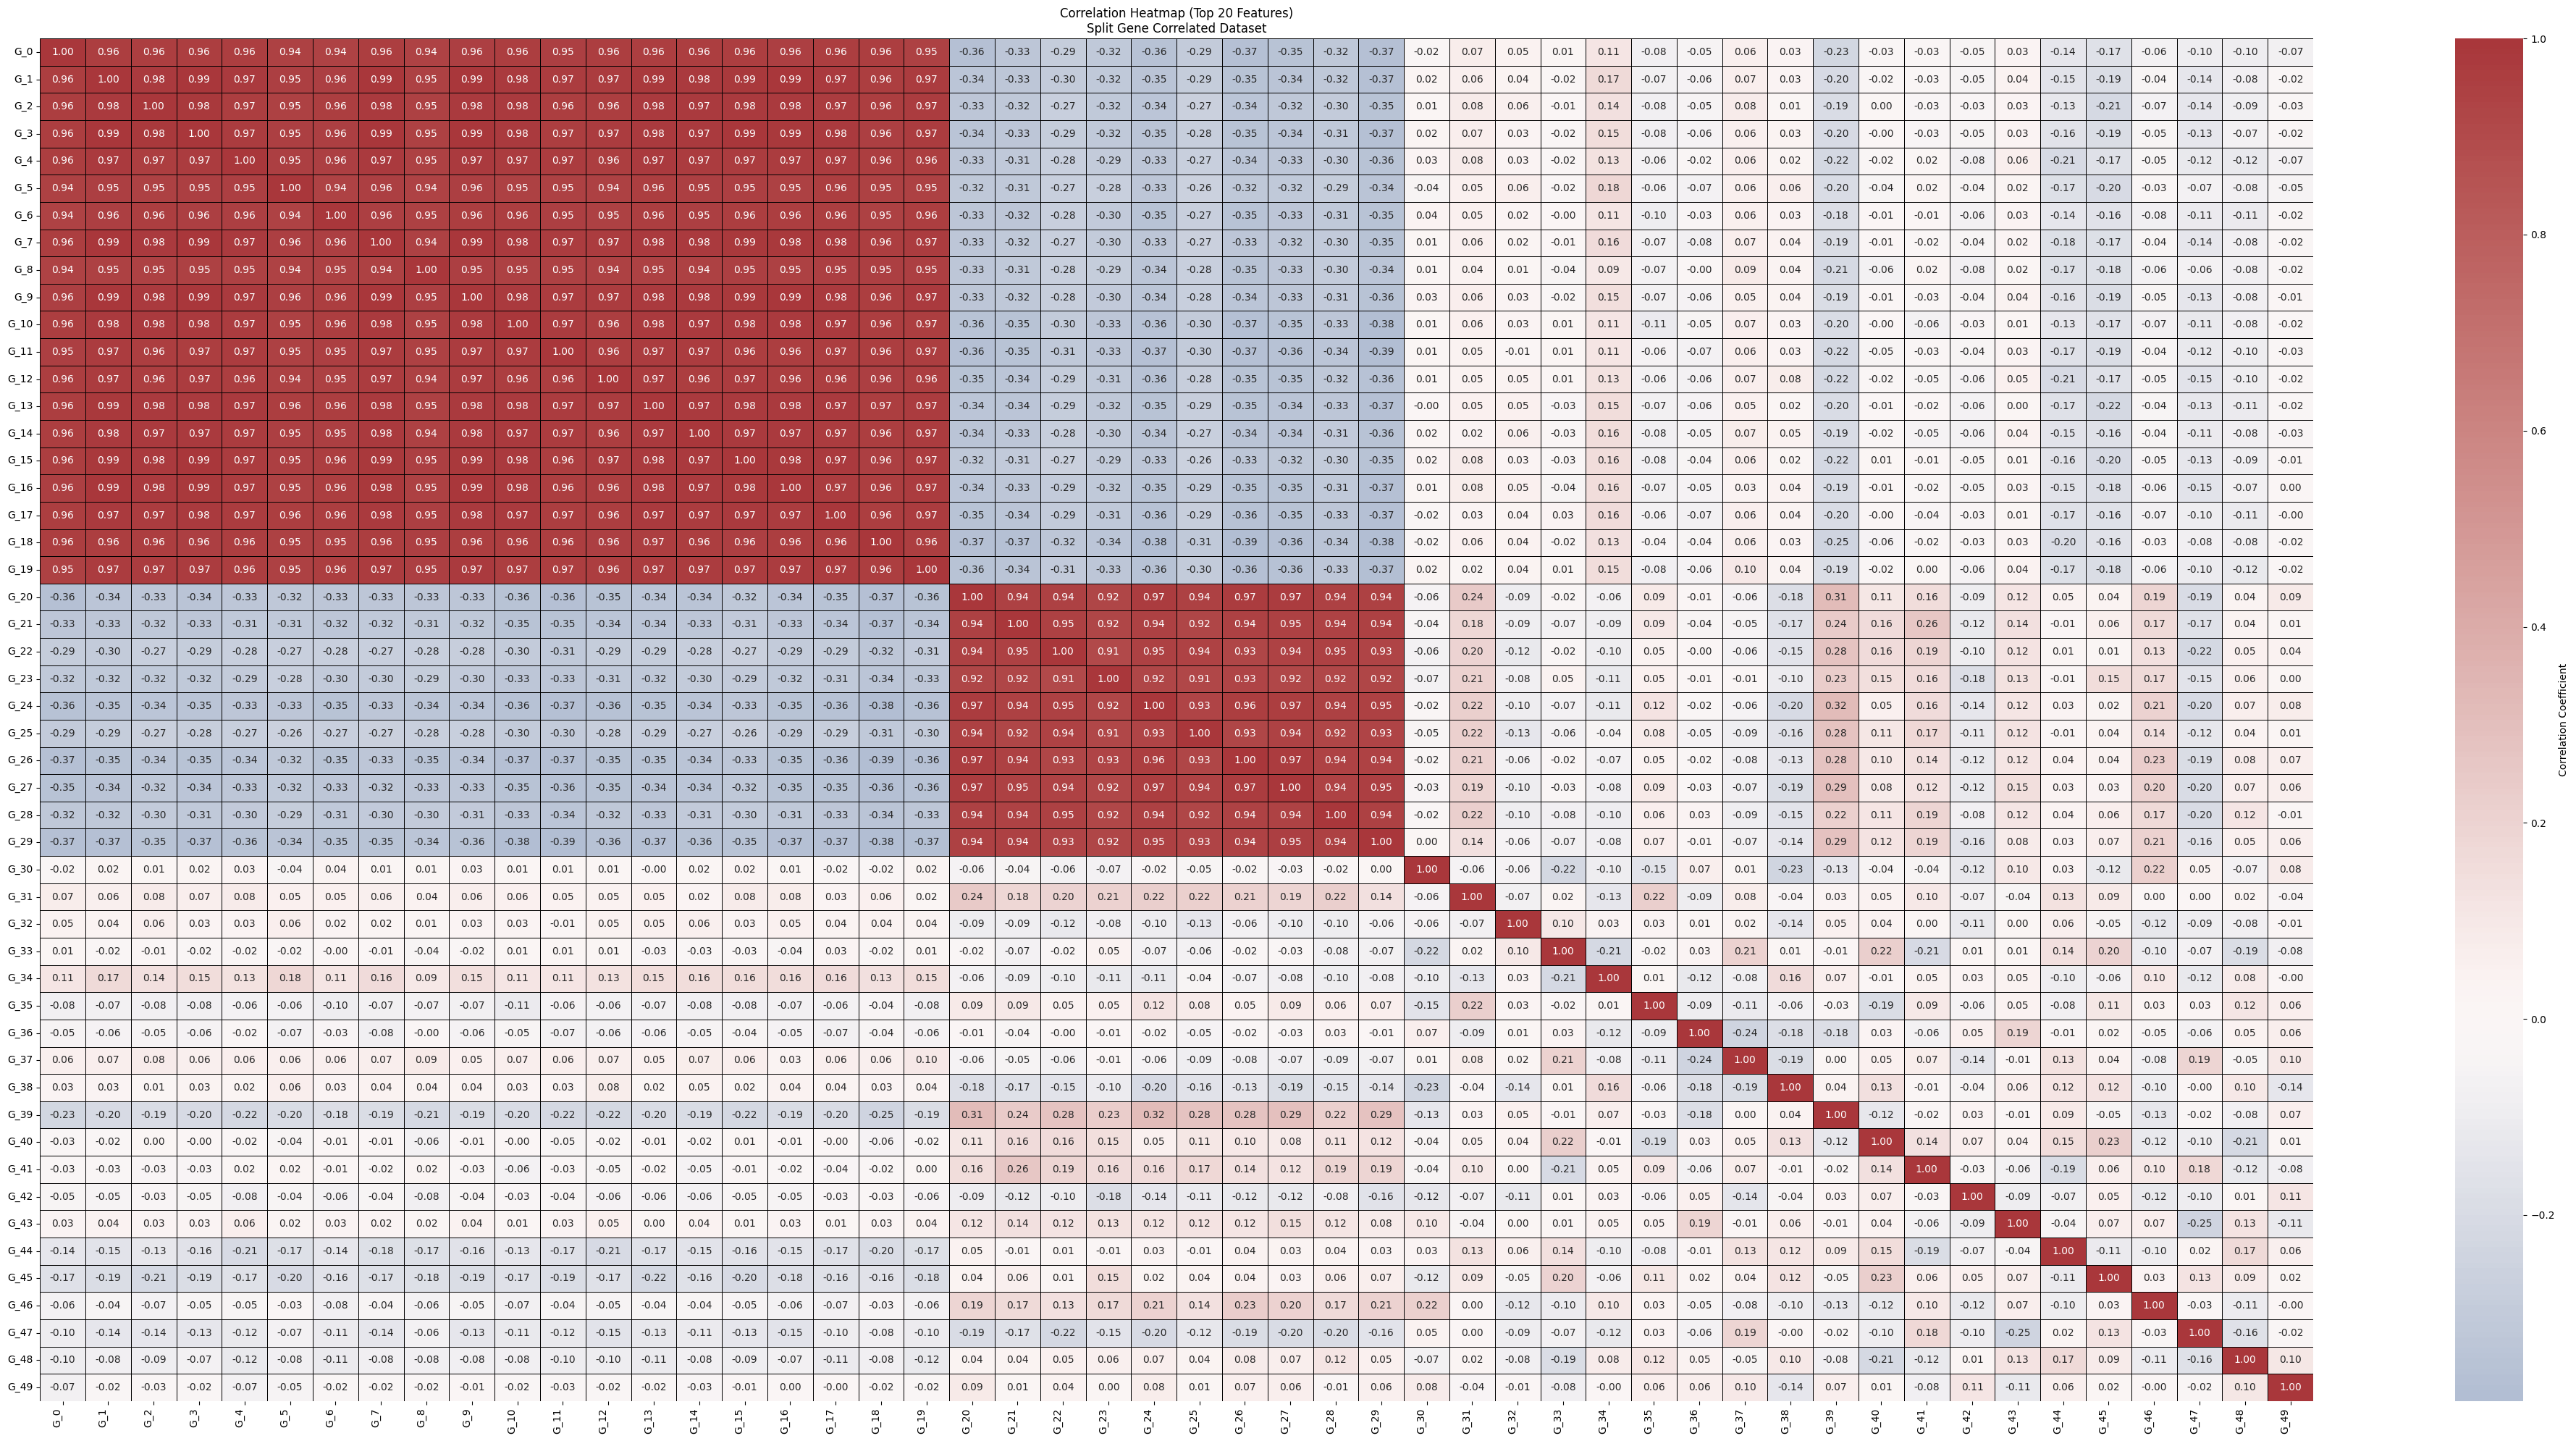

In [7]:
# Train and evaluate the models
train_and_evaluate(df_gene, "Gene Dataset with Disease Effect")
train_and_evaluate(df_minimal, "Minimal Effect Gene Dataset")
train_and_evaluate(df_split, "Split Gene Correlated Dataset")

In [8]:
# Generate the datasets
df_gene = create_gene_dataset_with_disease_effect(
    n_samples=100, # Number of patients
    n_genes=15000,
    num_disease_genes=15000, # Half of the genes correlated with disease
    gene_type="Microarray", # Or "RNA-Seq"
    disease_effect_type="additive_shift", # "additive_shift" for Microarray, "fold_change" for RNA-Seq
    disease_effect_value=[8, 10], # Use a range for a uniform stochastic effect
)

df_minimal = create_minimal_effect_gene_dataset(
    n_samples=100,
    n_genes=15000,
    num_disease_genes=3000,
    num_correlated_genes=3000,
    correlation_value=0.8,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_value=[0.05, 0.15], # Use a range for a minimal, uniform stochastic effect
)

df_split = create_split_gene_correlated_dataset(
    n_samples=100,
    n_genes=15000,
    num_disease_genes_1=3000,
    num_disease_genes_2=2000,
    corr_group_1=0.6,
    corr_group_2=0.7,
    gene_type="Microarray",
    disease_effect_type="additive_shift",
    disease_effect_type_2="additive_shift",
    disease_effect_value=[20, 24],
    disease_effect_value_2=[10, 15],
    num_patients_subtype_1 = 25)


Starting gene dataset generation with 15000 genes, 15000 disease-correlated.


Generation complete.
Starting gene dataset generation with 15000 genes...
Introducing correlation for a group of 3000 genes.
Generation complete.
Starting gene dataset generation with 15000 genes...
Defining disease subtypes: 25 patients for module 1, remainder for module 2.
Generating gene data with disease subtypes...
Generation complete.


In [9]:
# --- Configuración General ---
N_CLUSTERS = 100           # Número de clústeres de genes
N_COMPONENTS_PCA = 2       # Para el gráfico 2D de PCA/UMAP
N_TOP_CLUSTERS_TO_SHOW = 15   # Para los gráficos de resumen


def train_and_evaluate_cluster(df, dataset_filename):
    """
    Flujo de trabajo "notebook" mejorado (sin guardado de archivos):
    - Muestra todos los gráficos en ventanas emergentes (plt.show()).
    - Imprime resúmenes en la consola (print).
    - Añade UMAP estático.
    - Añade un Clustermap "Top-K" anotado.
    """
    print("--- Modo de visualización 'Notebook' activo (sin guardado) ---")
    print("Resultados se mostrarán en consola y ventanas emergentes.")

    print(f"\n{'='*60}")
    print(f"Processing dataset: {dataset_filename}")
    print(f"{'='*60}")
    
    try:
        df_clean = df.drop(columns=['Unnamed: 0'], errors='ignore')
        X = df_clean.iloc[:, :-1]
        y = df_clean.iloc[:, -1]
        
        gene_names = X.columns.tolist()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42, stratify=y
        )

        # --- 1. Escalar Datos ---
        print("\n[1] Scaling data (StandardScaler)...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Preparar datos completos para visualización
        X_scaled_full = np.vstack((X_train_scaled, X_test_scaled))
        y_full = pd.concat([y_train, y_test])

        # --- 2a. Visualización PCA (de Muestras) con Seaborn ---
        print(f"\n[2a] Generating PCA plot ({N_COMPONENTS_PCA} components)...")
        n_components_actual = min(N_COMPONENTS_PCA, X_train_scaled.shape[0], X_train_scaled.shape[1])
        if n_components_actual < N_COMPONENTS_PCA:
                print(f"Warning: Reducing PCA components to {n_components_actual} due to data shape.")
        
        pca = PCA(n_components=n_components_actual)
        X_pca = pca.fit_transform(X_scaled_full)
        
        pca_df = pd.DataFrame(
            data=X_pca, 
            columns=[f'PC{i+1}' for i in range(n_components_actual)]
        )
        pca_df['Group'] = y_full.astype(str).values 

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            data=pca_df, 
            x='PC1', 
            y='PC2', 
            hue='Group',
            palette='bright', s=50, alpha=0.7
        )
        plt.title(f'PCA of Samples (Colored by Group) - {dataset_filename}', fontsize=16)
        plt.xlabel(f'PC1 (Explains {pca.explained_variance_ratio_[0]:.2%} variance)')
        if n_components_actual >= 2:
                plt.ylabel(f'PC2 (Explains {pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend(title='Group')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        print("Displaying PCA plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 2b. NUEVO: Visualización UMAP (de Muestras) con Seaborn ---
        print(f"\n[2b] Generating UMAP plot ({N_COMPONENTS_PCA} components)...")
        try:
            # UMAP necesita n_neighbors < n_samples
            n_neighbors = min(15, X_scaled_full.shape[0] - 1)
            if n_neighbors < 2:
                print("Warning: Not enough samples for UMAP. Skipping.")
            else:
                reducer = umap.UMAP(n_components=N_COMPONENTS_PCA, n_neighbors=n_neighbors, random_state=42)
                X_umap = reducer.fit_transform(X_scaled_full)
                
                umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
                umap_df['Group'] = y_full.astype(str).values

                plt.figure(figsize=(10, 8))
                sns.scatterplot(
                    data=umap_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    hue='Group',
                    palette='bright', s=50, alpha=0.7
                )
                plt.title(f'UMAP of Samples (Colored by Group) - {dataset_filename}', fontsize=16)
                plt.xlabel('UMAP 1')
                plt.ylabel('UMAP 2')
                plt.legend(title='Group')
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.tight_layout()
                
                print("Displaying UMAP plot (cierre la ventana para continuar)...")
                plt.show()
        except Exception as e:
            print(f"Error during UMAP generation: {e}. Skipping UMAP plot.")


        # --- 3. Agrupación de Features (Feature Agglomeration) ---
        n_features = X_train_scaled.shape[1]
        n_clusters_actual = min(N_CLUSTERS, n_features)
        if n_clusters_actual < N_CLUSTERS:
            print(f"Warning: Reducing cluster count to {n_clusters_actual} (equal to feature count).")
            
        print(f"\n[3] Clustering {len(gene_names)} features into {n_clusters_actual} groups...")
        agglo = FeatureAgglomeration(n_clusters=n_clusters_actual)
        agglo.fit(X_train_scaled)
        
        X_train_clustered = agglo.transform(X_train_scaled)
        X_test_clustered = agglo.transform(X_test_scaled)
        print(f"Data transformed from {X_train_scaled.shape[1]} to {X_train_clustered.shape[1]} features.")

        # --- 4. MOSTRAR EL MAPA DE GENES A CLÚSTERES (Visual) ---
        print(f"\n[4] Displaying gene-to-cluster mapping ...")
        cluster_map_df = pd.DataFrame({
            'Gene': gene_names,
            'ClusterID': agglo.labels_
        }).sort_values(by='ClusterID')
        
        # --- 4a. NUEVO: Gráfico de Distribución de Genes por Clúster ---
        print(f"\n[4a] Generating Gene-per-Cluster distribution plot...")
        
        # Calcular el tamaño de la figura dinámicamente
        fig_width = max(15, n_clusters_actual * 0.2)
        plt.figure(figsize=(fig_width, 8))
        
        cluster_order = sorted(cluster_map_df['ClusterID'].unique())
        
        # Usar countplot es más directo
        ax = sns.countplot(
            data=cluster_map_df,
            x='ClusterID',
            order=cluster_order,
            palette='viridis'
        )
        
        plt.title(f'Distribución de Genes por Clúster ({n_clusters_actual} Clústeres)\n{dataset_filename}', fontsize=16)
        plt.xlabel('Cluster ID', fontsize=12)
        plt.ylabel('Número de Genes (Count)', fontsize=12)
        
        # Manejo inteligente de etiquetas del eje X para evitar solapamiento
        if n_clusters_actual > 40:
            # Si hay demasiados, mostrar solo cada 5to label
            plt.xticks(rotation=90, fontsize=8)
            for i, label in enumerate(ax.get_xticklabels()):
                if (i % 5) != 0:
                    label.set_visible(False)
        elif n_clusters_actual > 15:
            # Rotar si hay una cantidad media
            plt.xticks(rotation=45, ha='right', fontsize=10)
        else:
            # Mostrar todos si son pocos
            plt.xticks(fontsize=10)
            
        plt.grid(True, linestyle='--', alpha=0.5, axis='y')
        plt.tight_layout()
        
        print("Displaying Gene-per-Cluster plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 4b. NUEVO: Resumen de Mapeo en Consola (Agrupado) ---
        print(f"\n[4b] Gene-to-Cluster Mapping Summary (Sample per cluster):")
        
        # Agrupar genes por clúster
        cluster_groups = cluster_map_df.groupby('ClusterID')['Gene'].apply(list)
        
        # Mostrar los primeros 20 clústeres como muestra
        clusters_to_show = cluster_groups.head(20)
        
        for cluster_id, gene_list in clusters_to_show.items():
            total_genes = len(gene_list)
            if total_genes > 5:
                # Mostrar los primeros 3 y cuántos más
                sample_genes = f"{', '.join(gene_list[:3])}, ... (+{total_genes - 3} más)"
            else:
                # Mostrar todos si son 5 o menos
                sample_genes = ", ".join(gene_list)
            
            print(f"  Cluster {cluster_id} ({total_genes} genes): {sample_genes}")

        if len(cluster_groups) > 20:
            print(f"  ... (y {len(cluster_groups) - 20} clústeres más no mostrados en este resumen)")
        
        # --- 5. Entrenar Modelo sobre Clústeres ---
        print(f"\n[5] Training model on {n_clusters_actual} clustered features...")
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        model.fit(X_train_clustered, y_train)
        
        predictions = model.predict(X_test_clustered)
        accuracy = accuracy_score(y_test, predictions)
        print(f"Model Accuracy on {n_clusters_actual} clusters: {accuracy:.4f}")

        # --- 6. Importancia de Clústeres (Permutation Importance) ---
        print(f"\n[6] Calculating Permutation Importance for {n_clusters_actual} clusters...")
        cluster_names = [f'Cluster_{i}' for i in range(n_clusters_actual)]
        
        perm_importance = permutation_importance(
            model, X_test_clustered, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        perm_imp_df = pd.DataFrame({
            'Cluster': cluster_names,
            'ImportanceMean': perm_importance.importances_mean,
            'ImportanceStd': perm_importance.importances_std
        }).sort_values(by='ImportanceMean', ascending=False)
        
        print("Top 10 Most Important Gene Clusters (Consola):")
        print(perm_imp_df.head(10).to_string())
        
        
        # --- 6a. Gráfico de Barras de Permutation Importance ---
        print(f"\n[6a] Generating Permutation Importance plot (Top {N_TOP_CLUSTERS_TO_SHOW})...")
        n_top_actual = min(N_TOP_CLUSTERS_TO_SHOW, n_clusters_actual)
        top_clusters_df = perm_imp_df.head(n_top_actual).sort_values(by='ImportanceMean', ascending=True)

        plt.figure(figsize=(12, 8))
        plt.barh(
            top_clusters_df['Cluster'],
            top_clusters_df['ImportanceMean'],
            align='center', alpha=0.8, capsize=5
        )
        plt.title(f'Top {n_top_actual} Most Important Gene Clusters\n{dataset_filename}', fontsize=16)
        plt.xlabel('Importance (Mean Decrease in Accuracy)', fontsize=12)
        plt.ylabel('Gene Cluster', fontsize=12)
        plt.margins(y=0.01)
        plt.grid(True, linestyle='--', alpha=0.5, axis='x')
        plt.tight_layout()
        
        print("Displaying Permutation Importance plot (cierre la ventana para continuar)...")
        plt.show()

        # --- 7a. Clustermap COMPLETO (Sin etiquetas) ---
        print(f"\n[7a] Generating FULL clustermap ({n_clusters_actual} clusters)...")
        print(f"Note: Ocultando etiquetas para mejor visibilidad de la estructura.")
        
        X_train_clustered_df = pd.DataFrame(X_train_clustered, columns=cluster_names)
        corr_matrix_clusters = X_train_clustered_df.corr()
        
        fig_size_dim = min(20, max(12, n_clusters_actual * 0.15)) 
        
        g = sns.clustermap(
            corr_matrix_clusters,
            figsize=(fig_size_dim, fig_size_dim),
            cmap='vlag',
            annot=False,
            linewidths=.2,
            center=0,
            xticklabels=False,
            yticklabels=False
        )
        g.fig.suptitle(f'Clustermap de Correlación (TODOS {n_clusters_actual} Clusters)\n{dataset_filename}', y=1.02, fontsize=16)

        print("Displaying FULL clustermap (cierre la ventana para continuar)...")
        plt.show()

        # --- 7b. NUEVO: Clustermap TOP-K (Con etiquetas y anotaciones) ---
        print(f"\n[7b] Generating TOP {n_top_actual} clustermap (con etiquetas)...")
        
        # Filtrar la matriz de correlación para incluir solo los clústeres Top-K
        top_cluster_names = perm_imp_df.head(n_top_actual)['Cluster'].tolist()
        corr_matrix_top_k = corr_matrix_clusters.loc[top_cluster_names, top_cluster_names]

        # El tamaño puede ser más pequeño y legible
        fig_size_top_k = max(10, n_top_actual * 0.7) 

        g_top = sns.clustermap(
            corr_matrix_top_k,
            figsize=(fig_size_top_k, fig_size_top_k),
            cmap='vlag',
            annot=True,     # <-- Mostrar valores
            fmt=".2f",      # <-- Formato de los valores
            linewidths=.5,
            center=0,
            xticklabels=True, # <-- Mostrar etiquetas
            yticklabels=True
        )
        
        g_top.fig.suptitle(f'Clustermap de Correlación (Top {n_top_actual} Clusters)\n{dataset_filename}', y=1.02, fontsize=16)
        plt.setp(g_top.ax_heatmap.get_xticklabels(), rotation=90)
        plt.setp(g_top.ax_heatmap.get_yticklabels(), rotation=0)

        print("Displaying TOP-K clustermap (cierre la ventana para continuar)...")
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {dataset_filename}: {e}")
        traceback.print_exc()

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Gene Dataset with Disease Effect - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


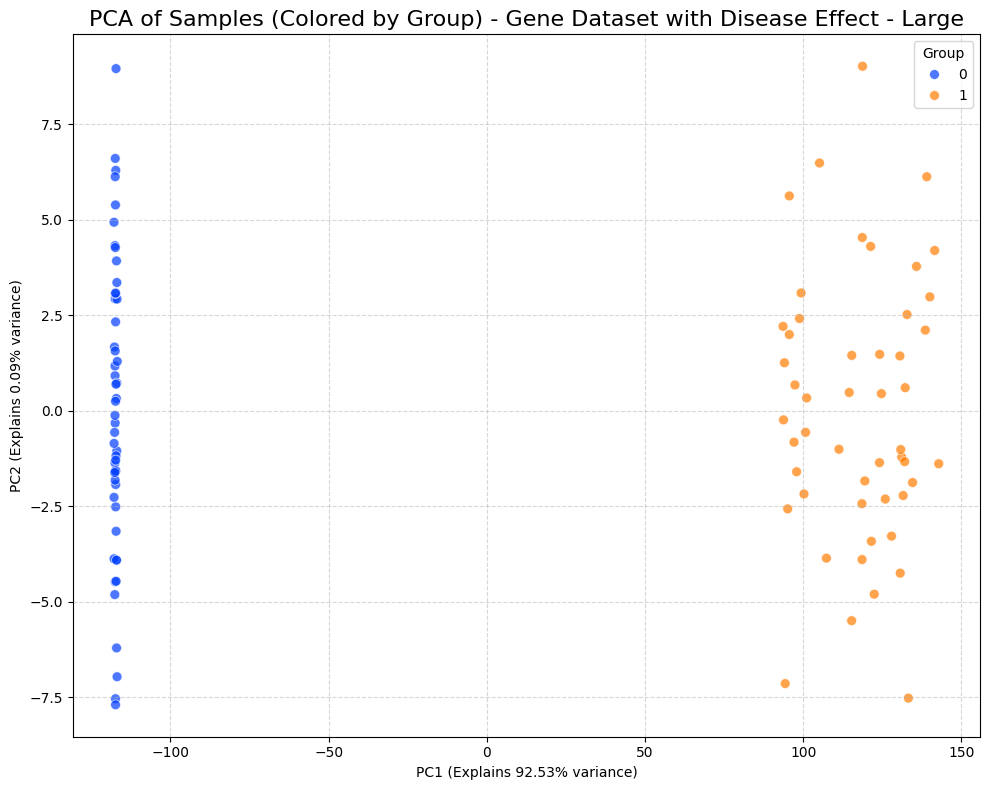


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...

[4a] Generating Gene-per-Cluster distribution plot...


/tmp/ipykernel_1443963/3147228724.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


Displaying Gene-per-Cluster plot (cierre la ventana para continuar)...


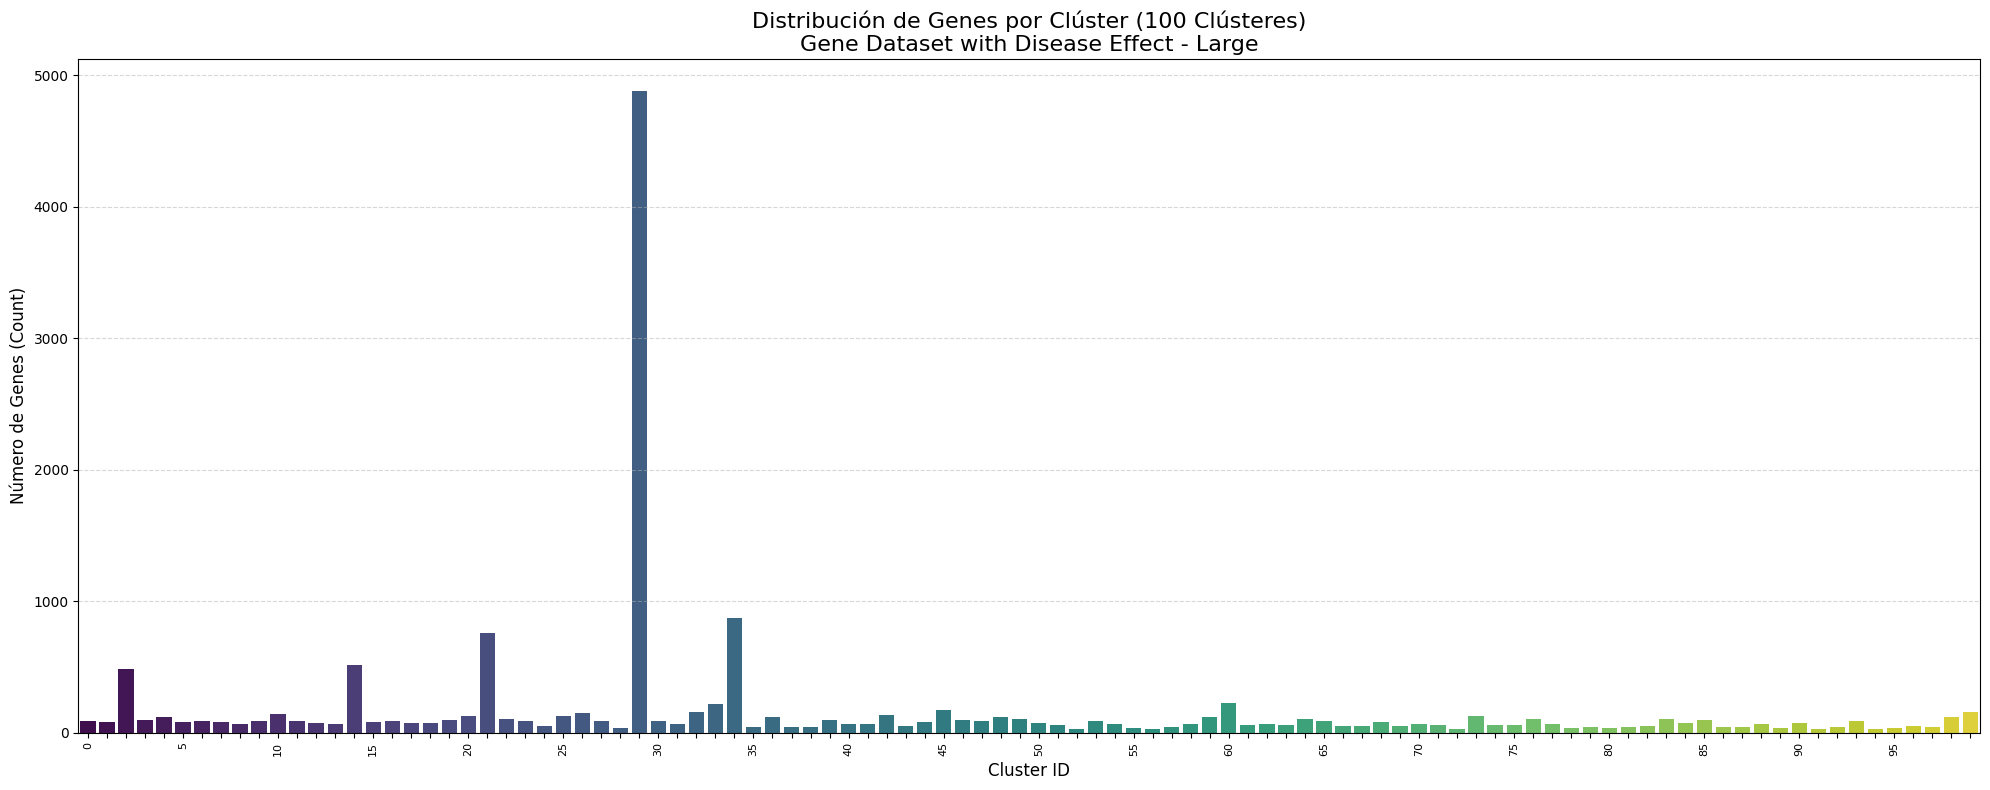


[4b] Gene-to-Cluster Mapping Summary (Sample per cluster):
  Cluster 0 (88 genes): G_7826, G_11857, G_5861, ... (+85 más)
  Cluster 1 (79 genes): G_9675, G_1101, G_3839, ... (+76 más)
  Cluster 2 (487 genes): G_2108, G_1154, G_8372, ... (+484 más)
  Cluster 3 (95 genes): G_7638, G_9075, G_6764, ... (+92 más)
  Cluster 4 (120 genes): G_7647, G_4543, G_7577, ... (+117 más)
  Cluster 5 (79 genes): G_6614, G_12442, G_14505, ... (+76 más)
  Cluster 6 (91 genes): G_5268, G_23, G_8967, ... (+88 más)
  Cluster 7 (83 genes): G_10628, G_12721, G_2913, ... (+80 más)
  Cluster 8 (64 genes): G_11087, G_14148, G_6030, ... (+61 más)
  Cluster 9 (88 genes): G_328, G_9715, G_14316, ... (+85 más)
  Cluster 10 (145 genes): G_957, G_6668, G_8192, ... (+142 más)
  Cluster 11 (88 genes): G_13819, G_11784, G_8715, ... (+85 más)
  Cluster 12 (72 genes): G_1821, G_6376, G_14069, ... (+69 más)
  Cluster 13 (62 genes): G_7365, G_1929, G_920, ... (+59 más)
  Cluster 14 (518 genes): G_3540, G_2332, G_1994, ... (+

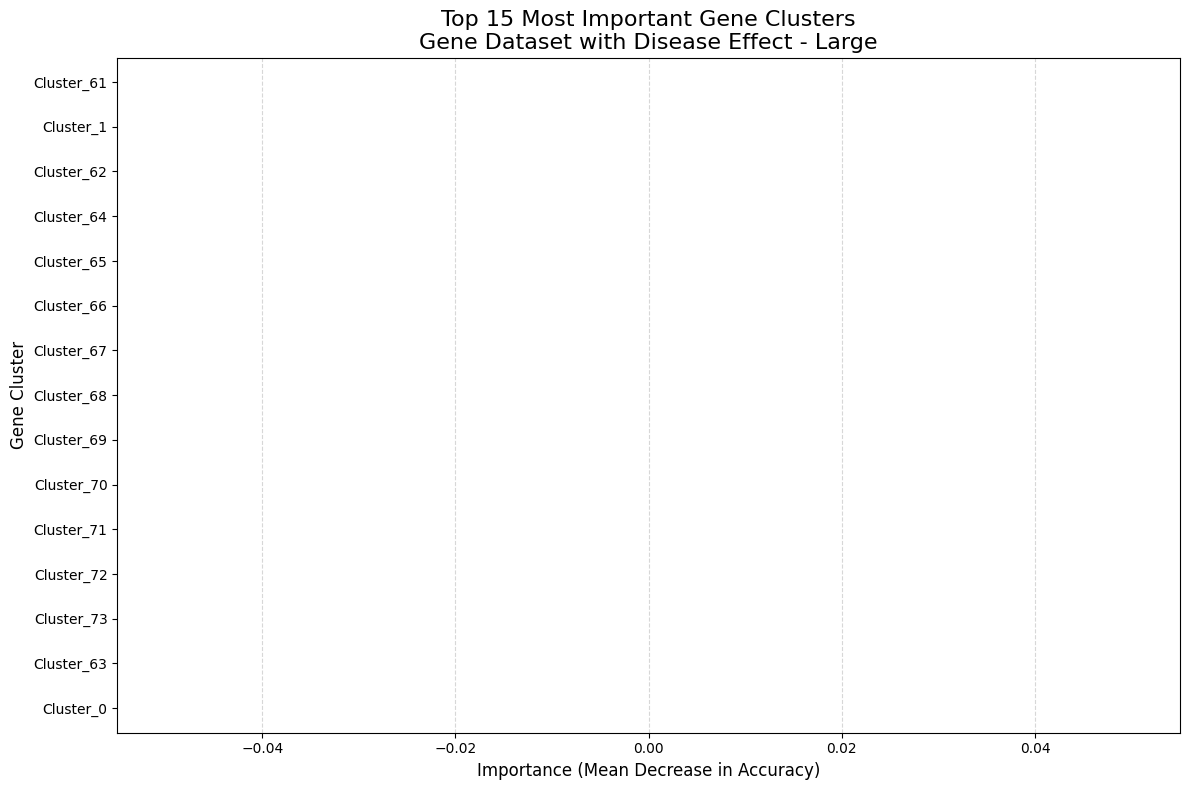


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


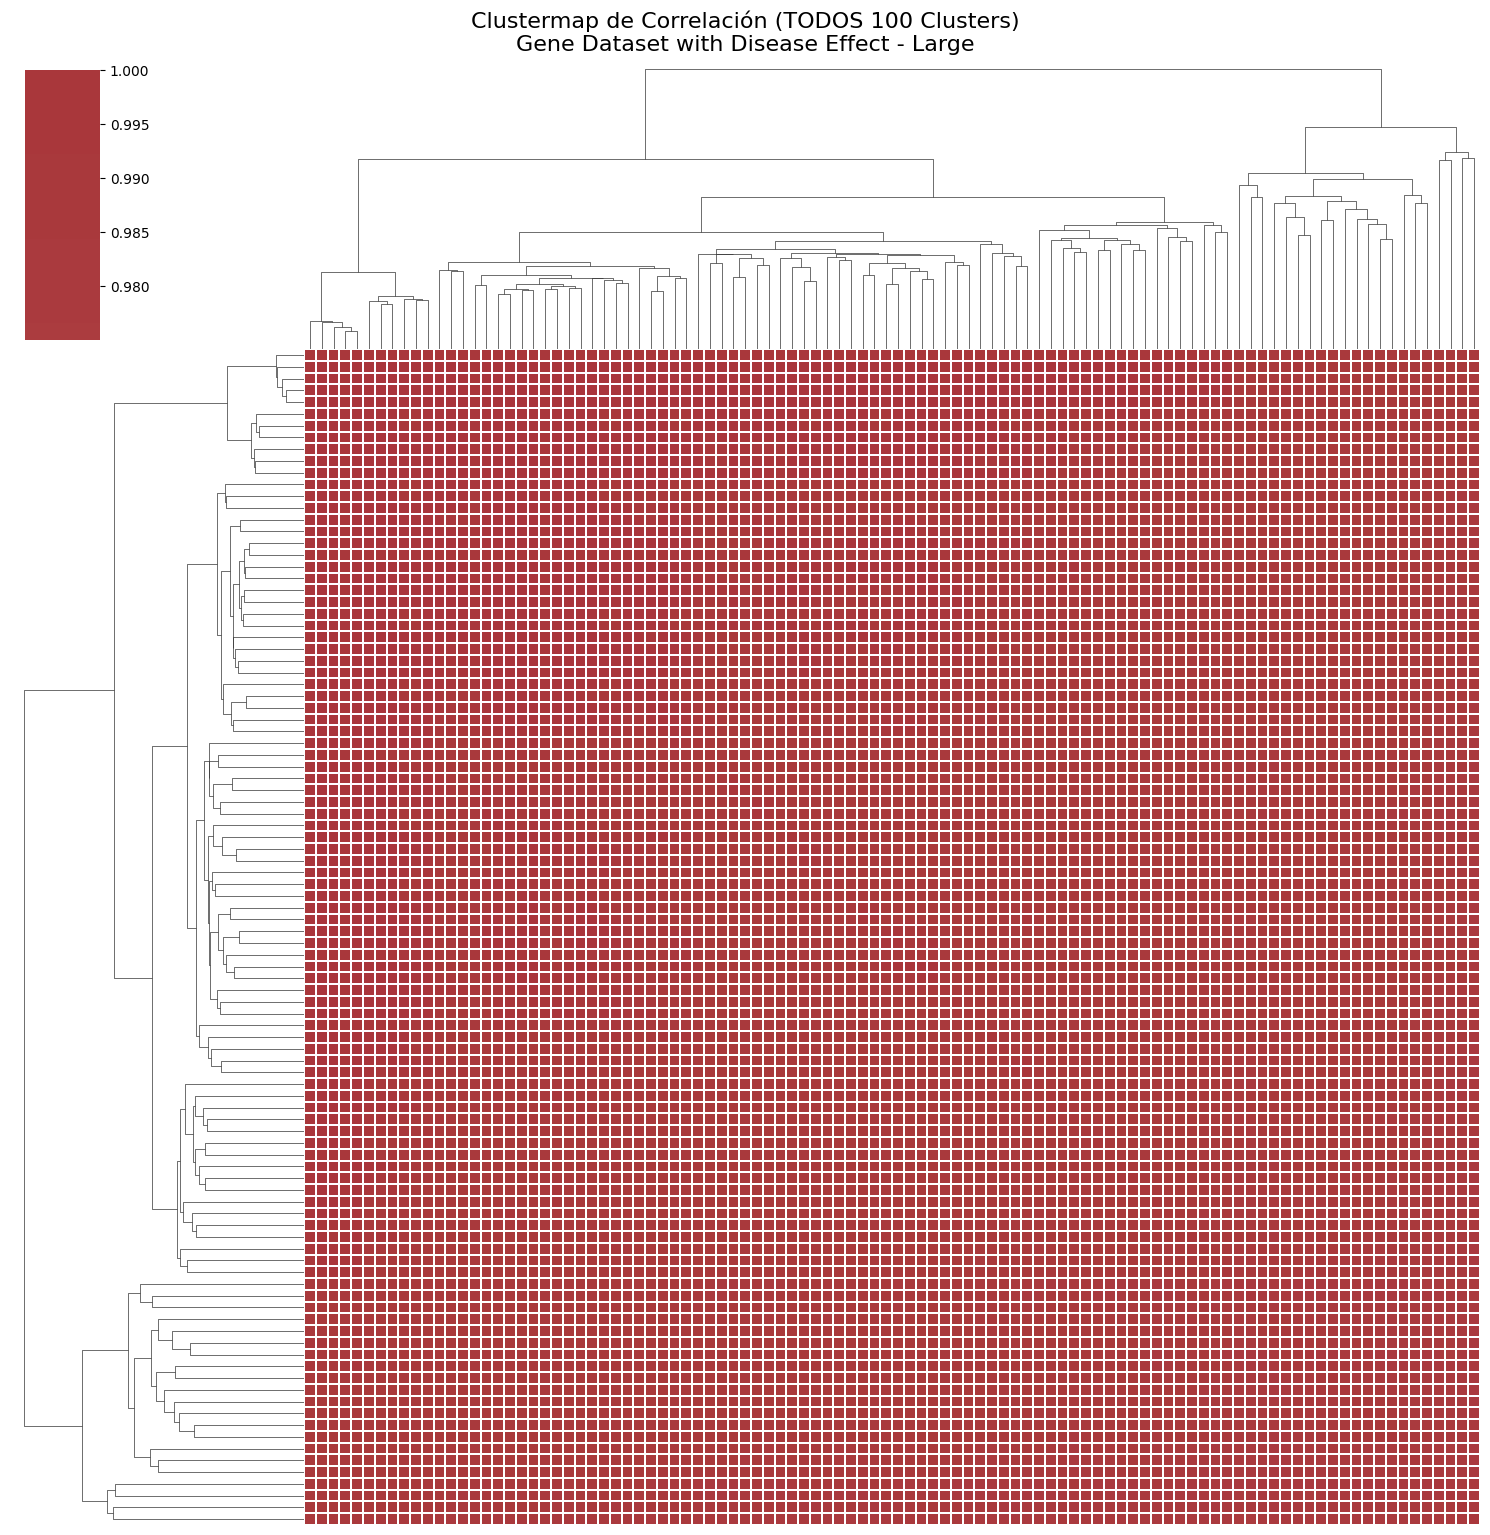


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


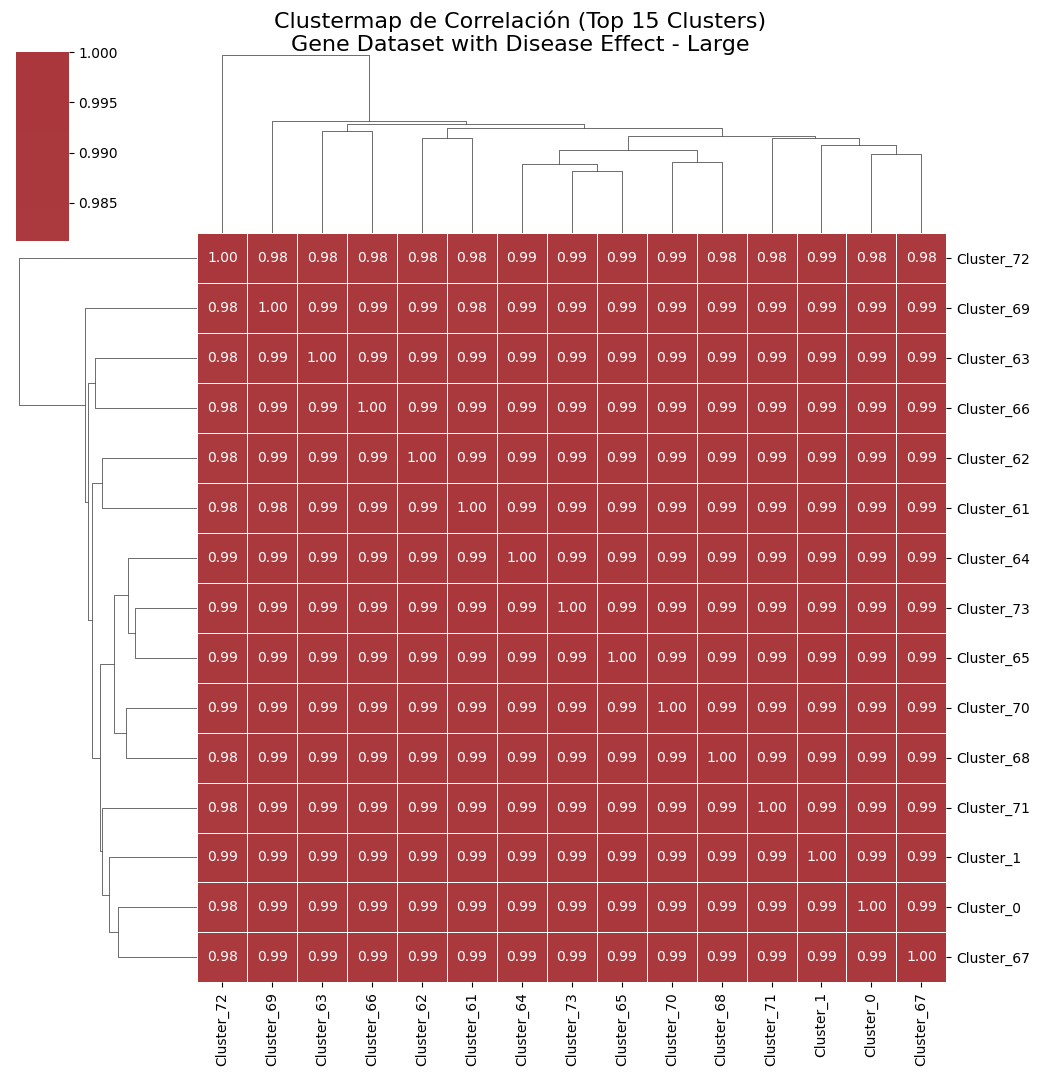

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Minimal Effect Gene Dataset - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


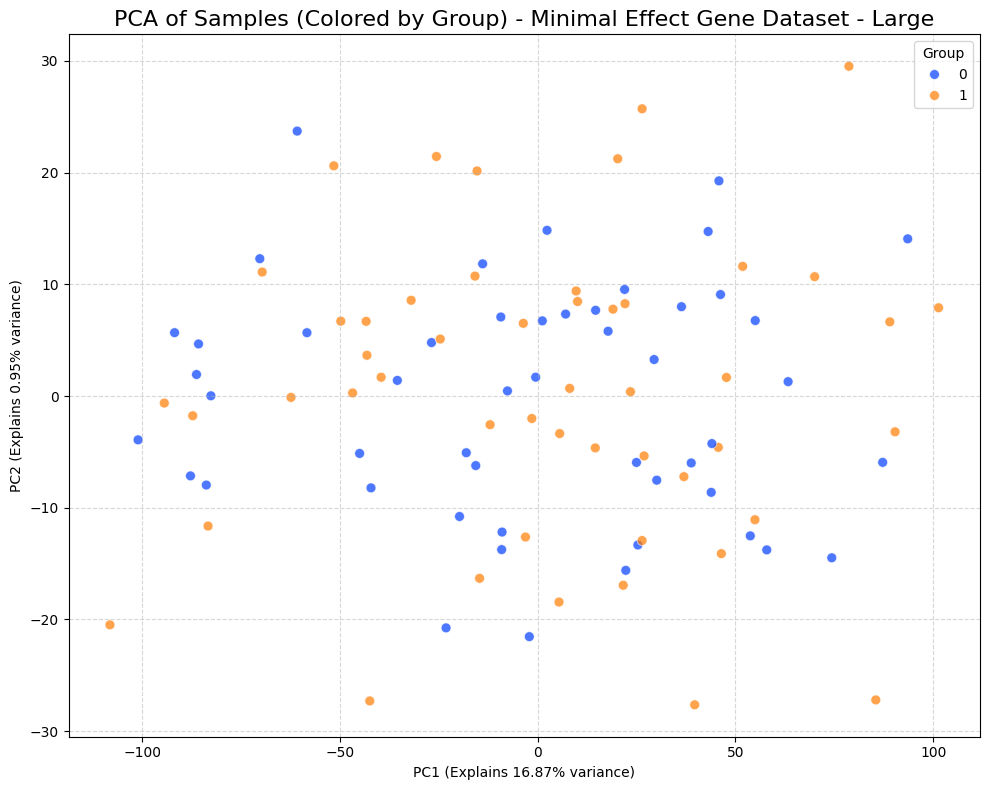


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...

[4a] Generating Gene-per-Cluster distribution plot...


/tmp/ipykernel_1443963/3147228724.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


Displaying Gene-per-Cluster plot (cierre la ventana para continuar)...


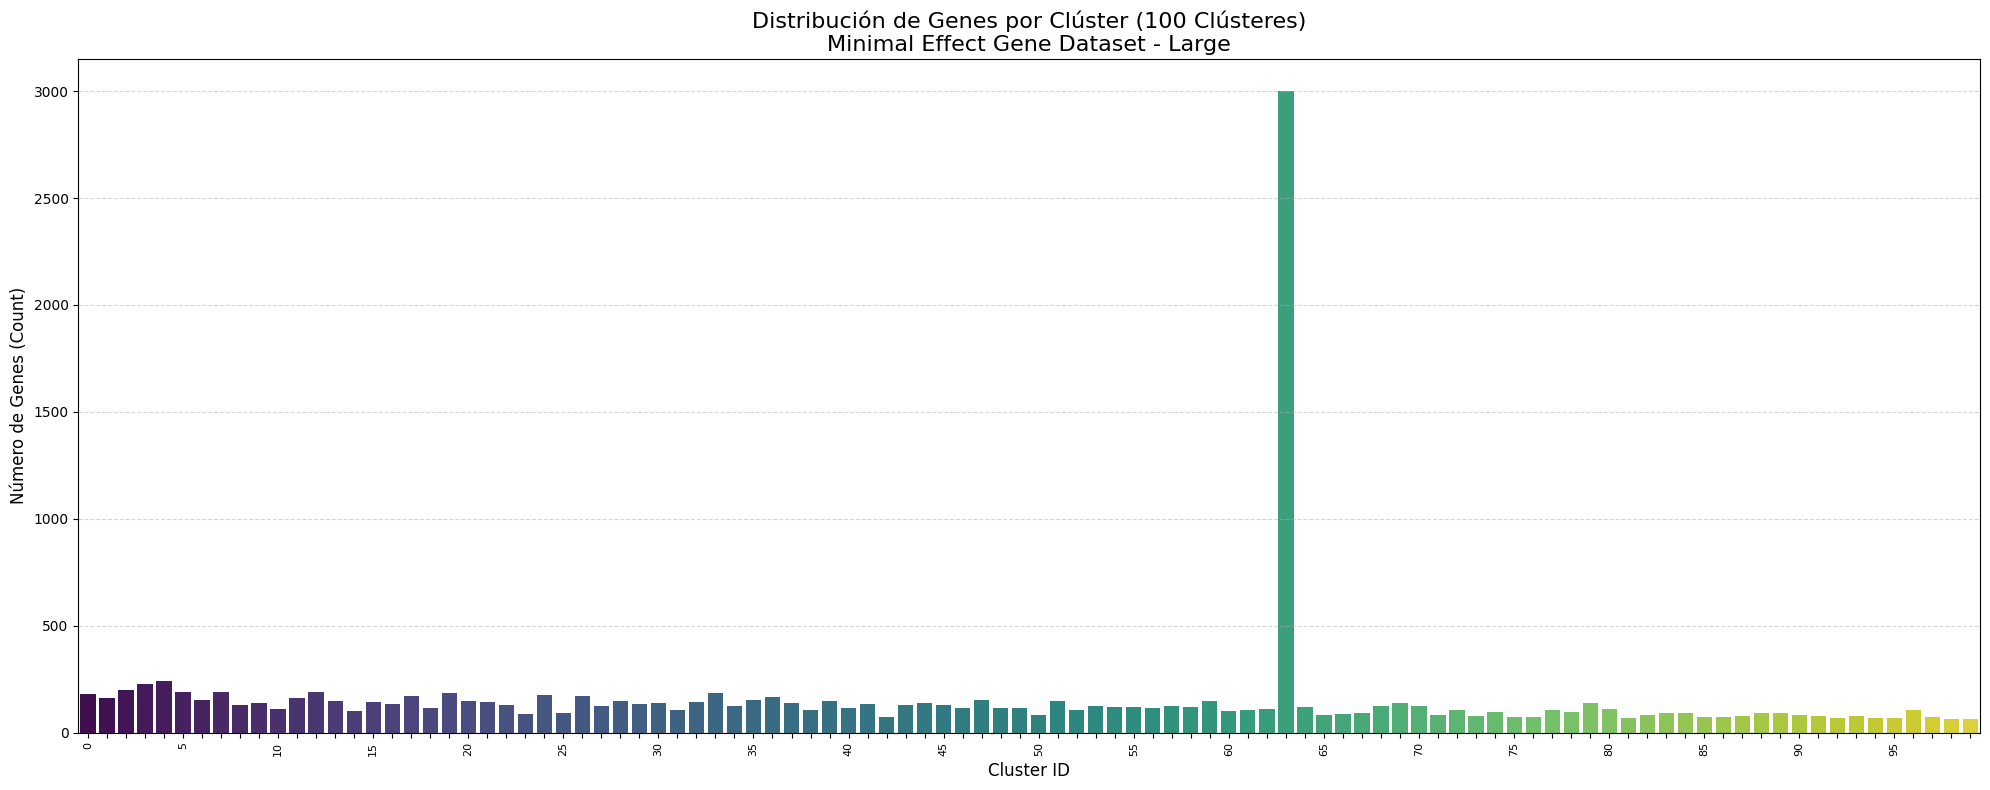


[4b] Gene-to-Cluster Mapping Summary (Sample per cluster):
  Cluster 0 (182 genes): G_3037, G_14368, G_4684, ... (+179 más)
  Cluster 1 (162 genes): G_9879, G_10857, G_10884, ... (+159 más)
  Cluster 2 (197 genes): G_6467, G_14944, G_10379, ... (+194 más)
  Cluster 3 (228 genes): G_3814, G_6568, G_6203, ... (+225 más)
  Cluster 4 (242 genes): G_11310, G_7284, G_7111, ... (+239 más)
  Cluster 5 (192 genes): G_6057, G_14038, G_13291, ... (+189 más)
  Cluster 6 (154 genes): G_8643, G_4503, G_9461, ... (+151 más)
  Cluster 7 (190 genes): G_12959, G_12006, G_13634, ... (+187 más)
  Cluster 8 (129 genes): G_14747, G_11249, G_5099, ... (+126 más)
  Cluster 9 (139 genes): G_9233, G_6056, G_5308, ... (+136 más)
  Cluster 10 (109 genes): G_6576, G_10398, G_11972, ... (+106 más)
  Cluster 11 (163 genes): G_3895, G_9242, G_3896, ... (+160 más)
  Cluster 12 (189 genes): G_13926, G_12406, G_11757, ... (+186 más)
  Cluster 13 (150 genes): G_9554, G_12808, G_12792, ... (+147 más)
  Cluster 14 (100 ge

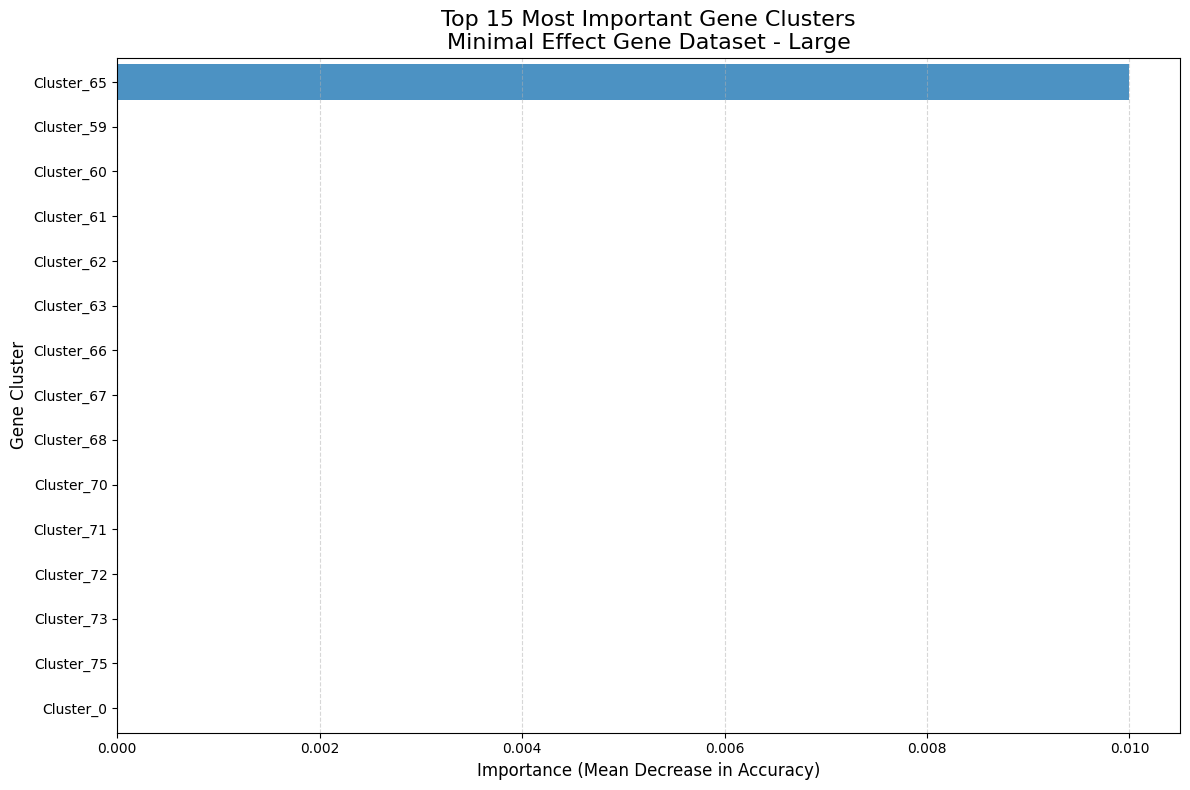


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


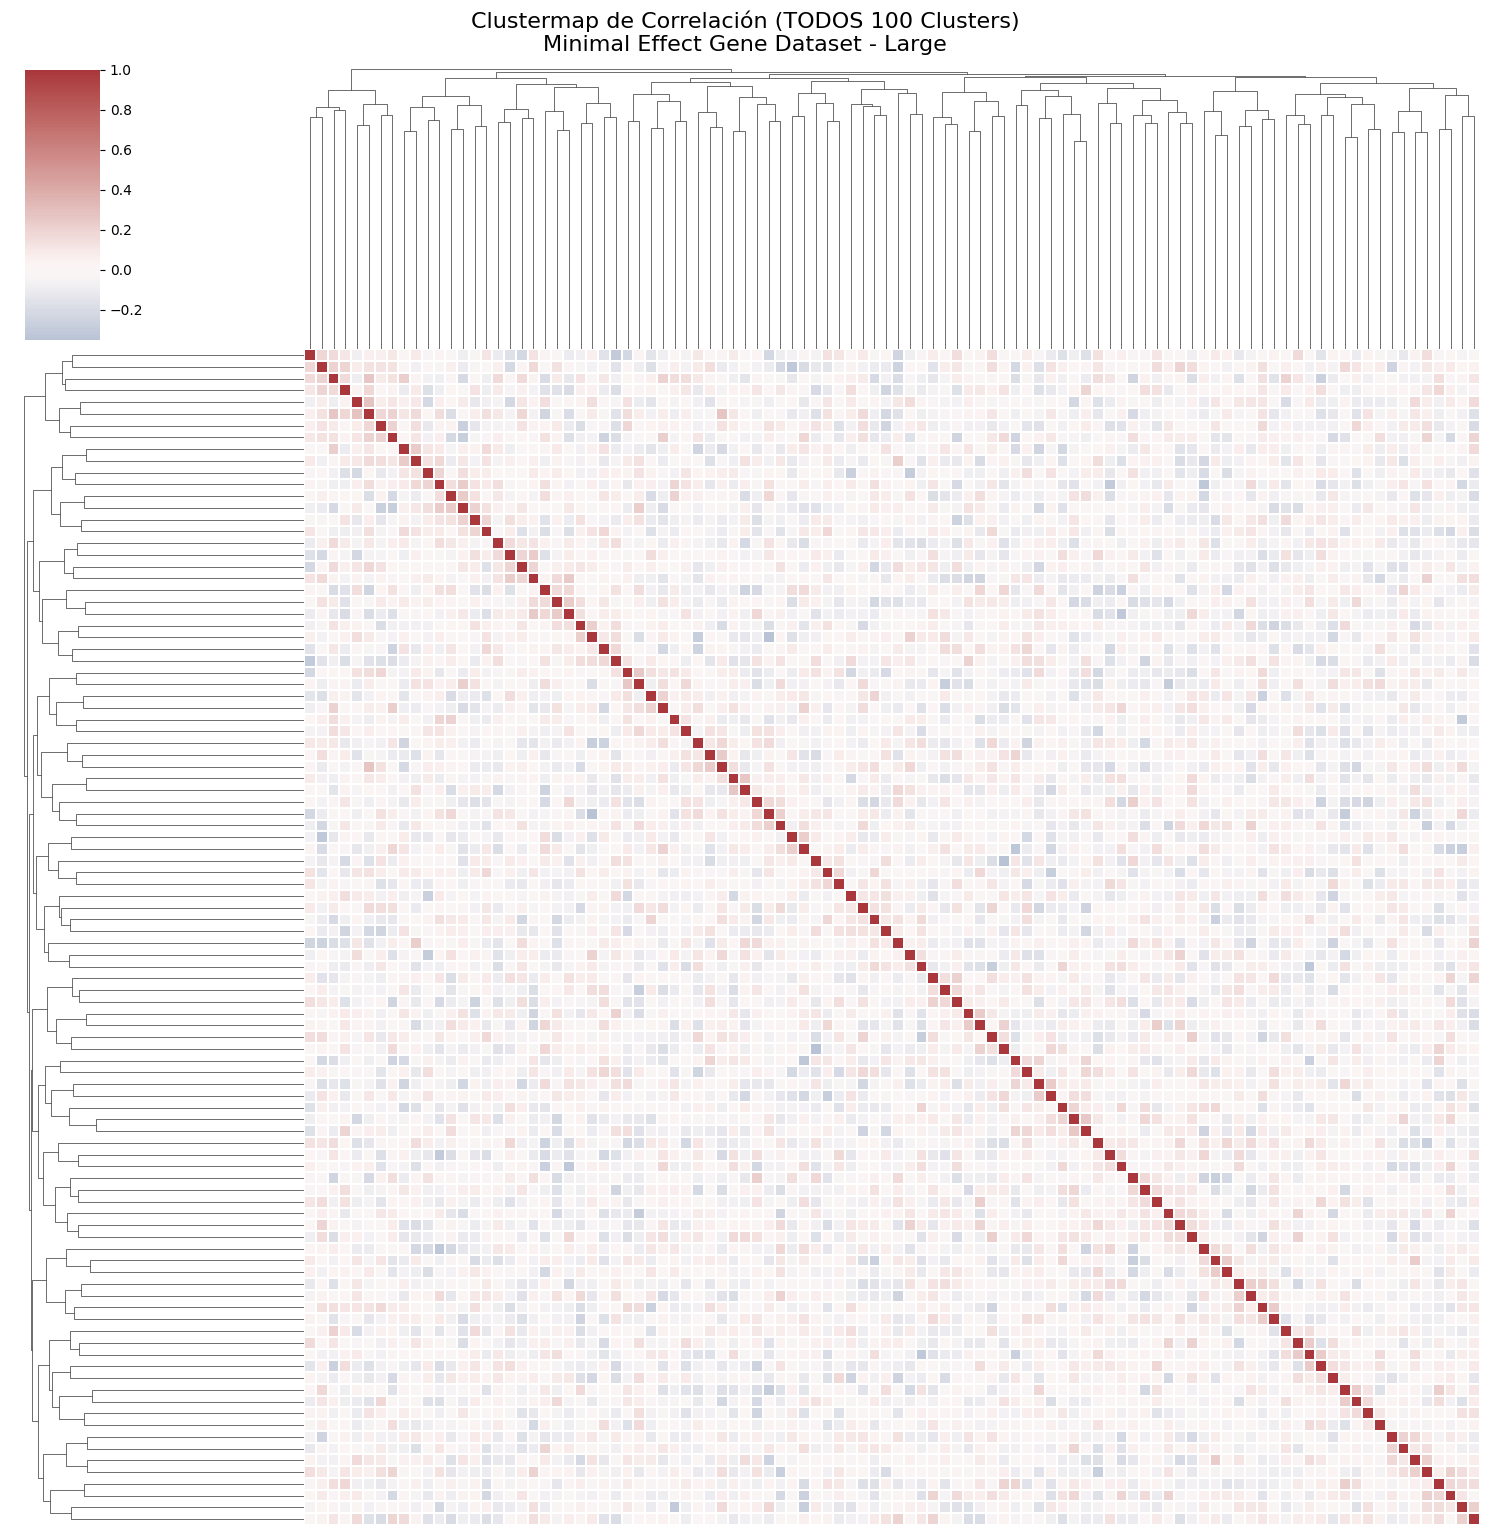


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


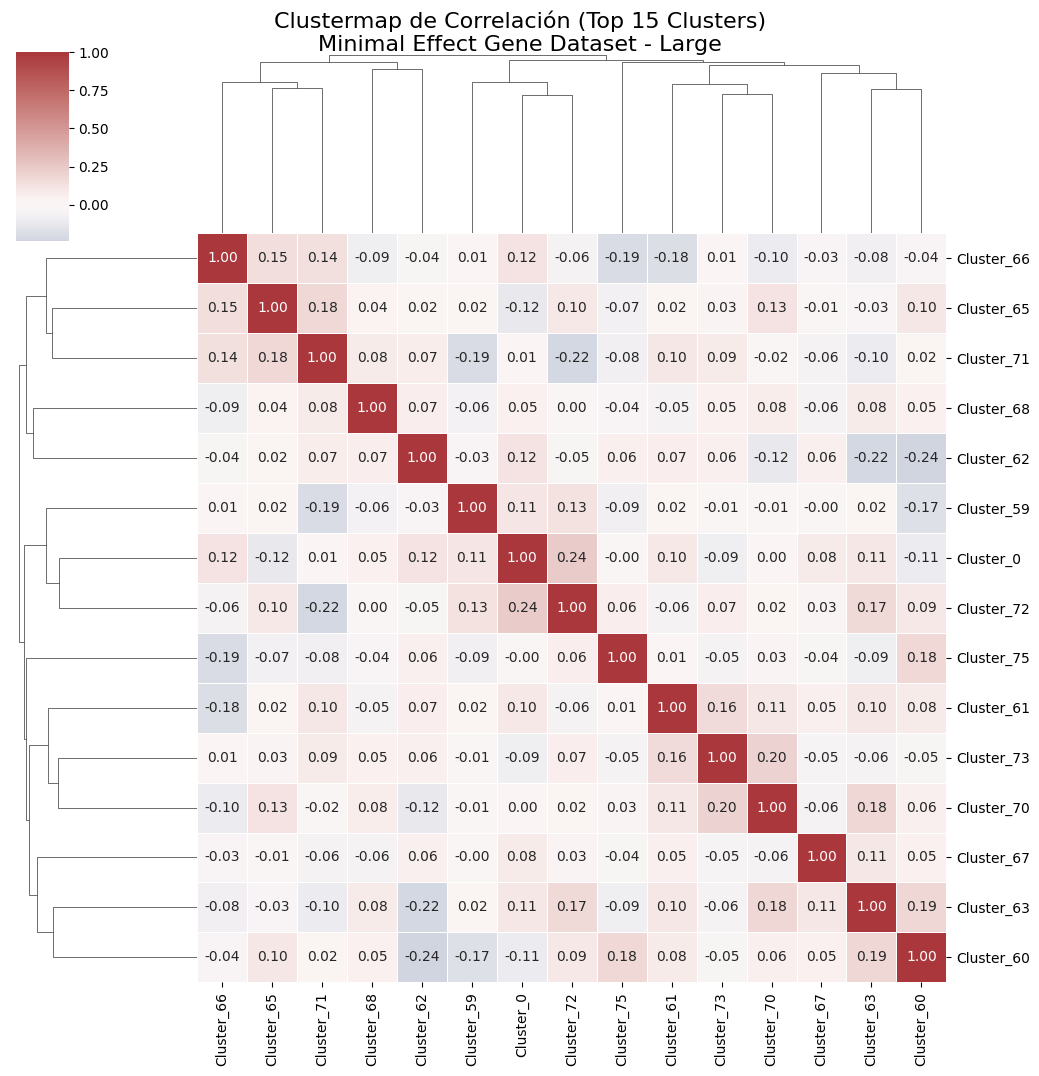

--- Modo de visualización 'Notebook' activo (sin guardado) ---
Resultados se mostrarán en consola y ventanas emergentes.

Processing dataset: Split Gene Correlated Dataset - Large

[1] Scaling data (StandardScaler)...

[2a] Generating PCA plot (2 components)...
Displaying PCA plot (cierre la ventana para continuar)...


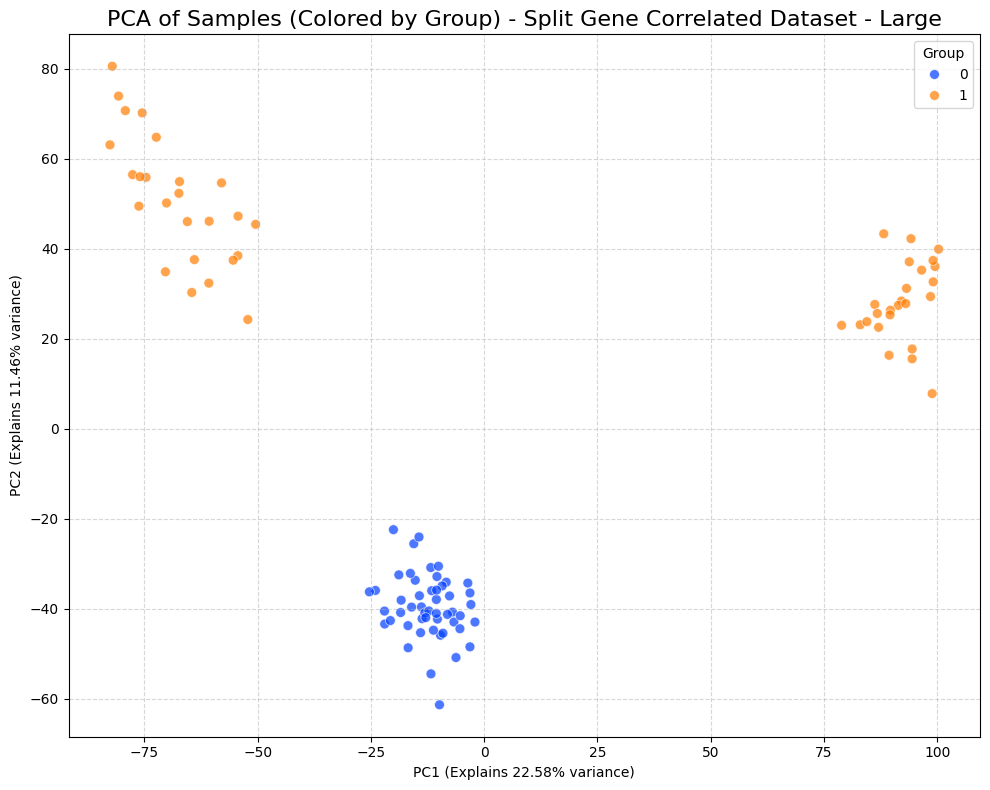


[2b] Generating UMAP plot (2 components)...
Error during UMAP generation: module 'umap' has no attribute 'UMAP'. Skipping UMAP plot.

[3] Clustering 15000 features into 100 groups...
Data transformed from 15000 to 100 features.

[4] Displaying gene-to-cluster mapping ...

[4a] Generating Gene-per-Cluster distribution plot...


/tmp/ipykernel_1443963/3147228724.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


Displaying Gene-per-Cluster plot (cierre la ventana para continuar)...


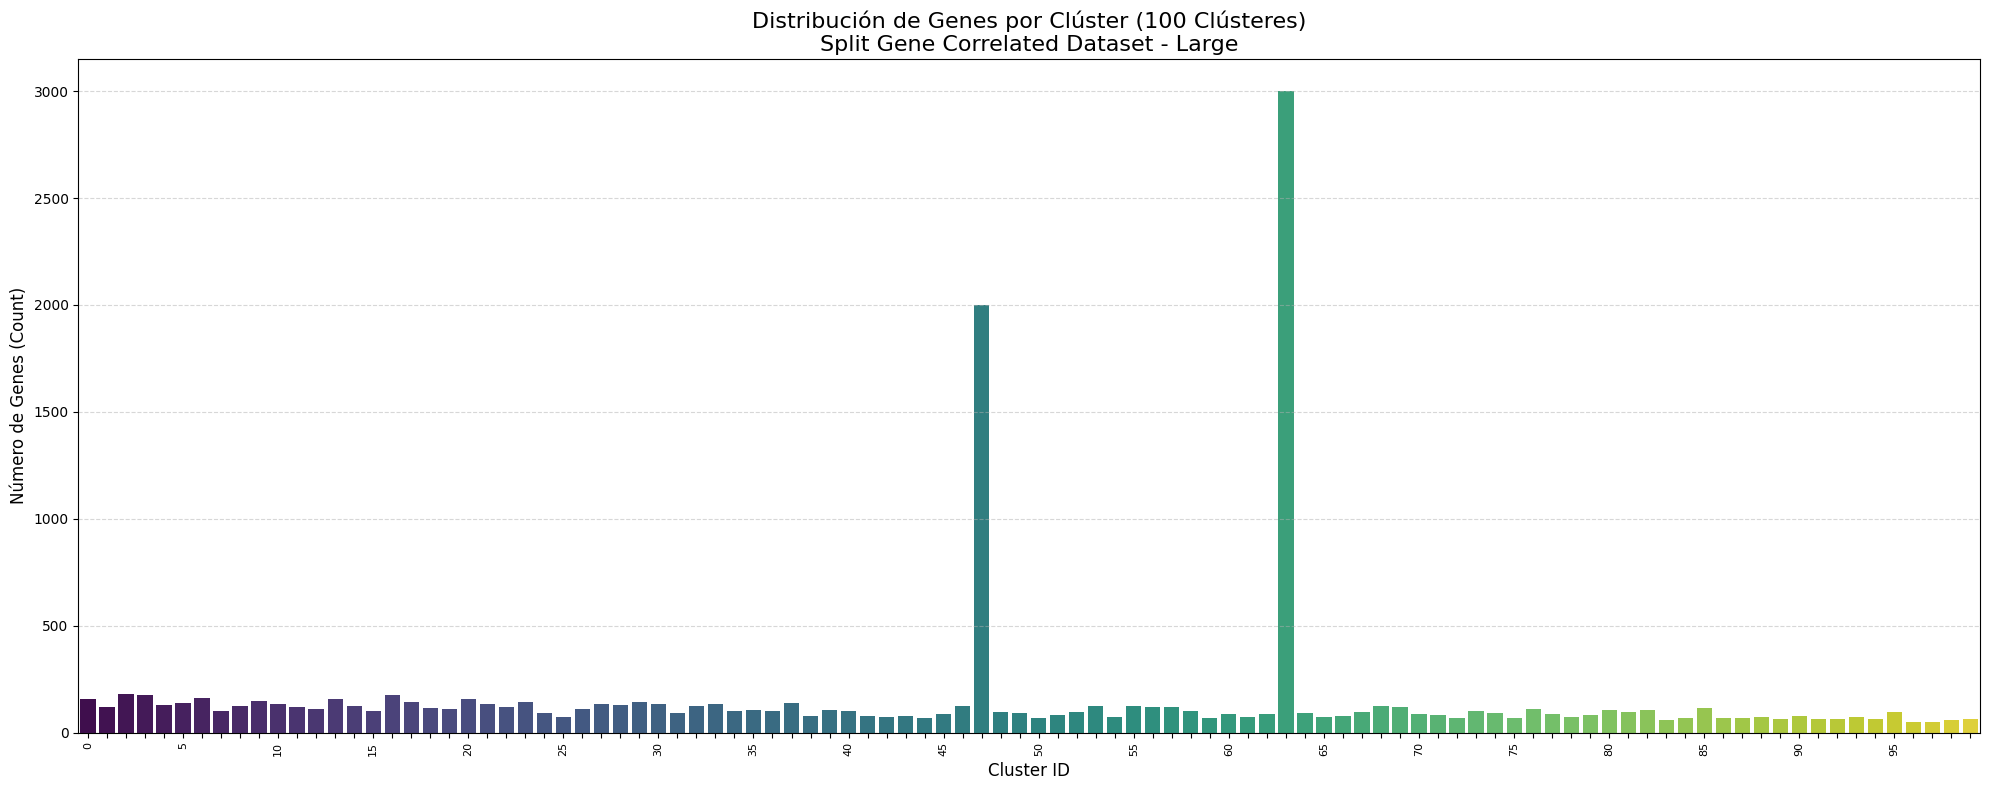


[4b] Gene-to-Cluster Mapping Summary (Sample per cluster):
  Cluster 0 (157 genes): G_8018, G_11279, G_11150, ... (+154 más)
  Cluster 1 (120 genes): G_12580, G_12684, G_6839, ... (+117 más)
  Cluster 2 (182 genes): G_5929, G_9687, G_5106, ... (+179 más)
  Cluster 3 (175 genes): G_9985, G_10132, G_12215, ... (+172 más)
  Cluster 4 (131 genes): G_8735, G_14291, G_12109, ... (+128 más)
  Cluster 5 (137 genes): G_9350, G_14961, G_6712, ... (+134 más)
  Cluster 6 (160 genes): G_11435, G_14046, G_13539, ... (+157 más)
  Cluster 7 (103 genes): G_10960, G_5904, G_6458, ... (+100 más)
  Cluster 8 (123 genes): G_9713, G_13959, G_9867, ... (+120 más)
  Cluster 9 (150 genes): G_11009, G_6366, G_10114, ... (+147 más)
  Cluster 10 (133 genes): G_10754, G_5366, G_5058, ... (+130 más)
  Cluster 11 (120 genes): G_12113, G_10270, G_14682, ... (+117 más)
  Cluster 12 (109 genes): G_13748, G_6289, G_9714, ... (+106 más)
  Cluster 13 (156 genes): G_11336, G_9039, G_13032, ... (+153 más)
  Cluster 14 (126

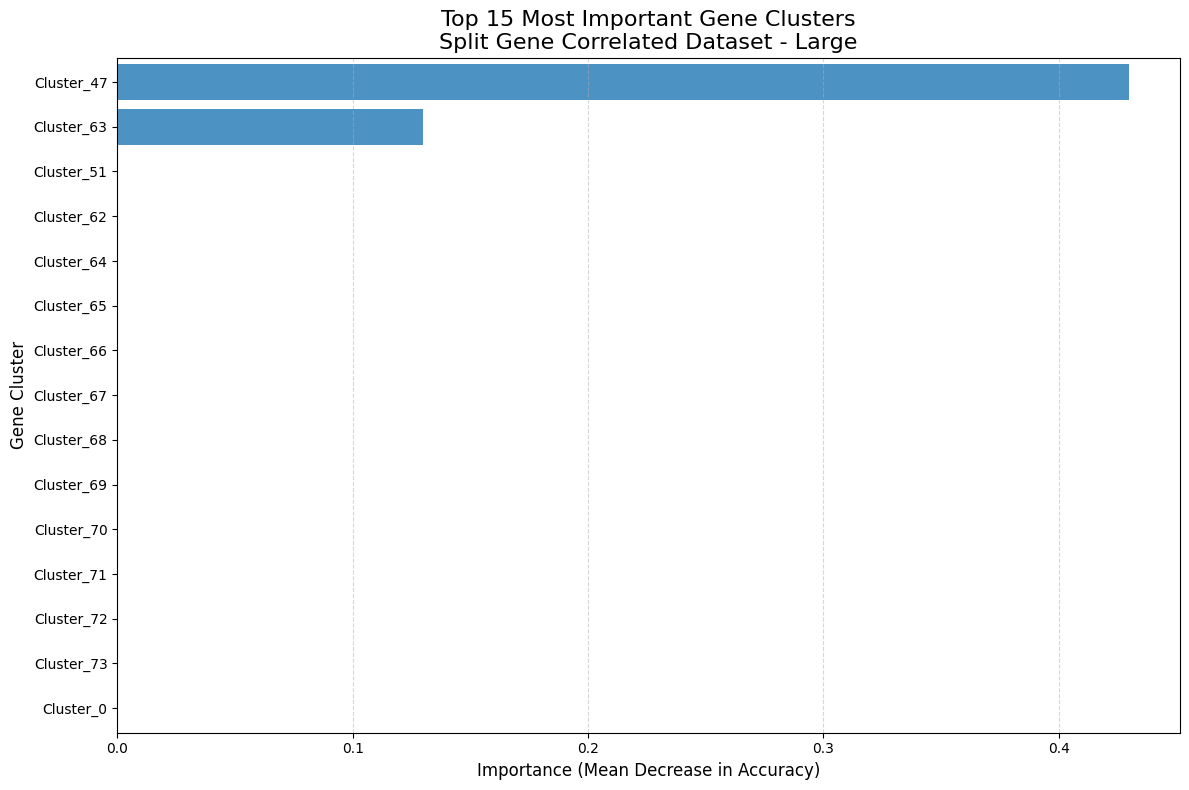


[7a] Generating FULL clustermap (100 clusters)...
Note: Ocultando etiquetas para mejor visibilidad de la estructura.
Displaying FULL clustermap (cierre la ventana para continuar)...


/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/alexbf/calmops-env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


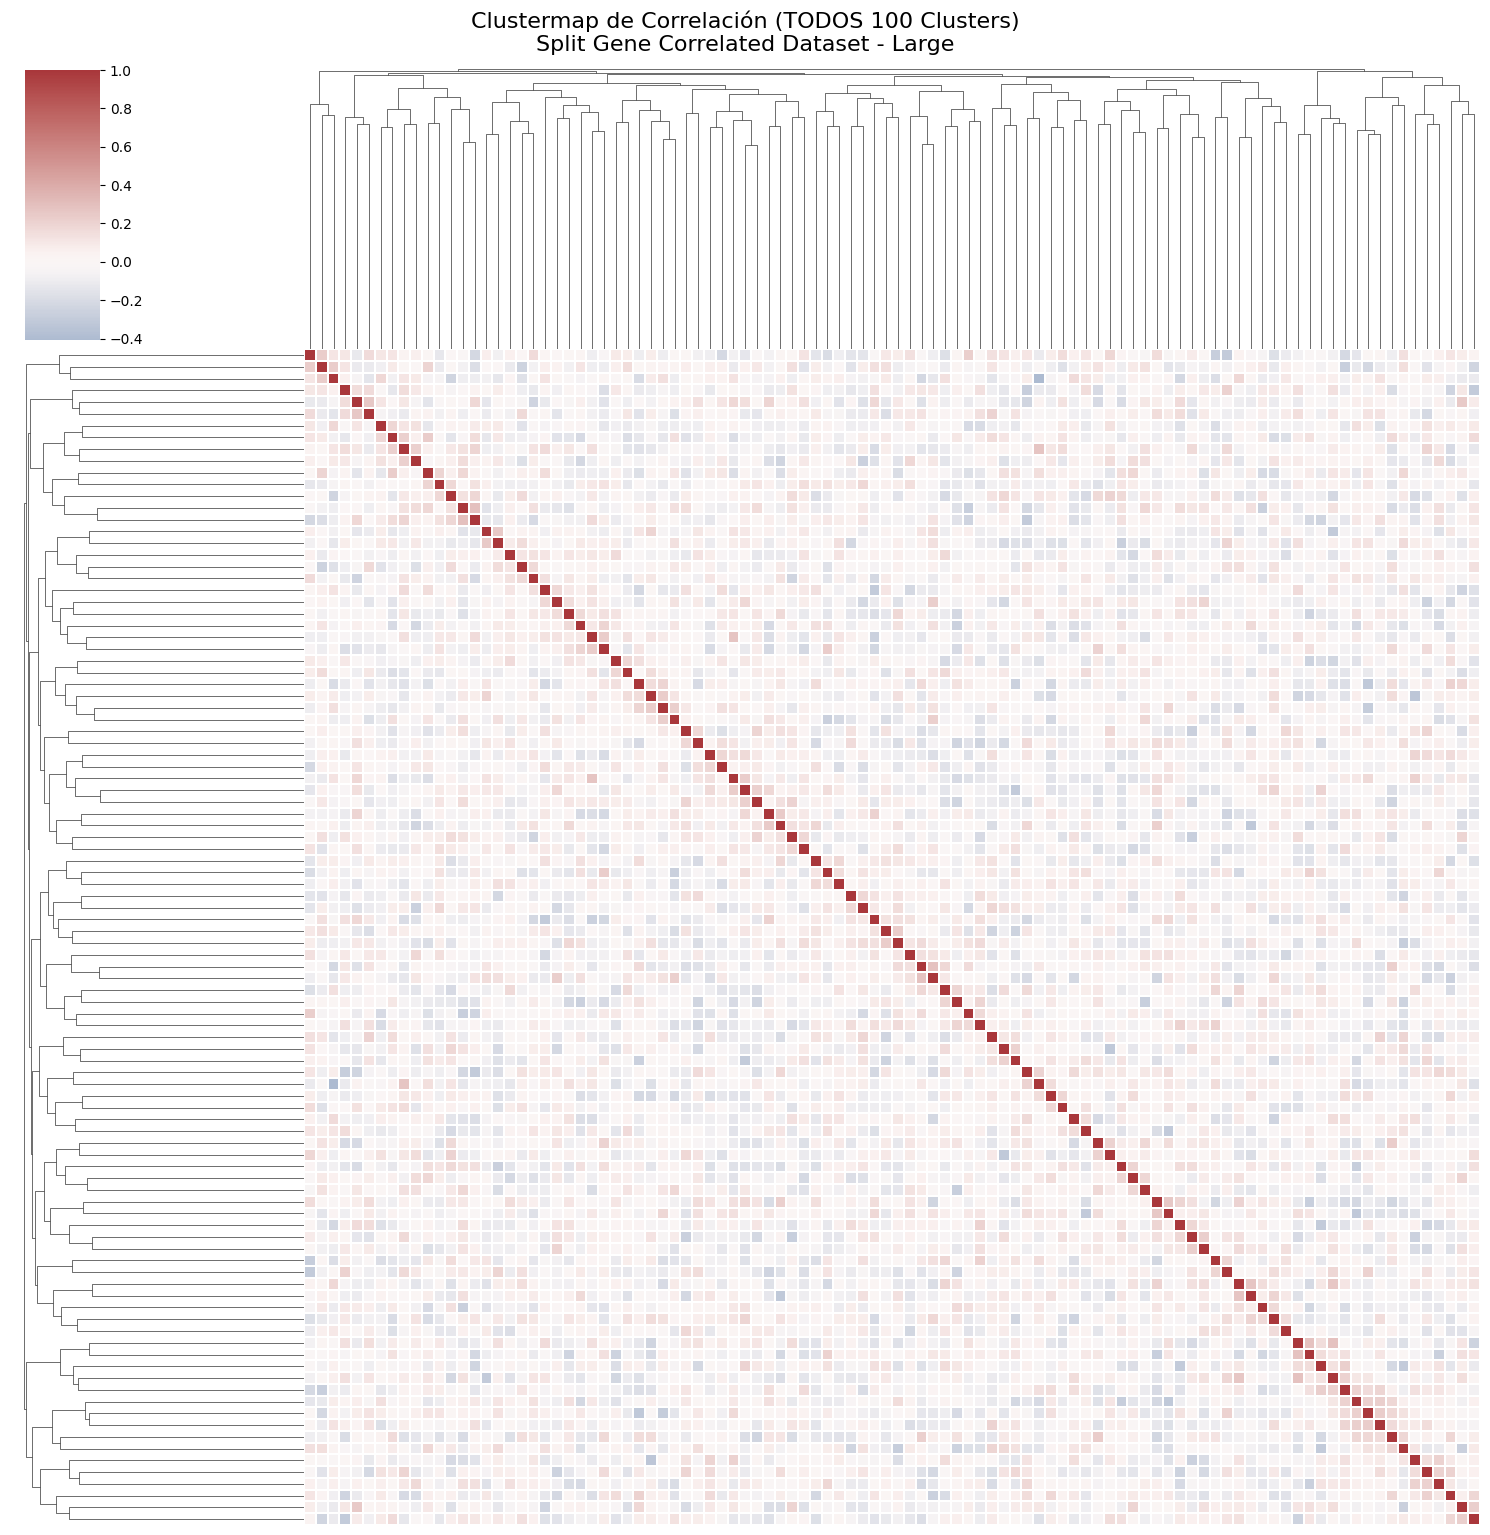


[7b] Generating TOP 15 clustermap (con etiquetas)...
Displaying TOP-K clustermap (cierre la ventana para continuar)...


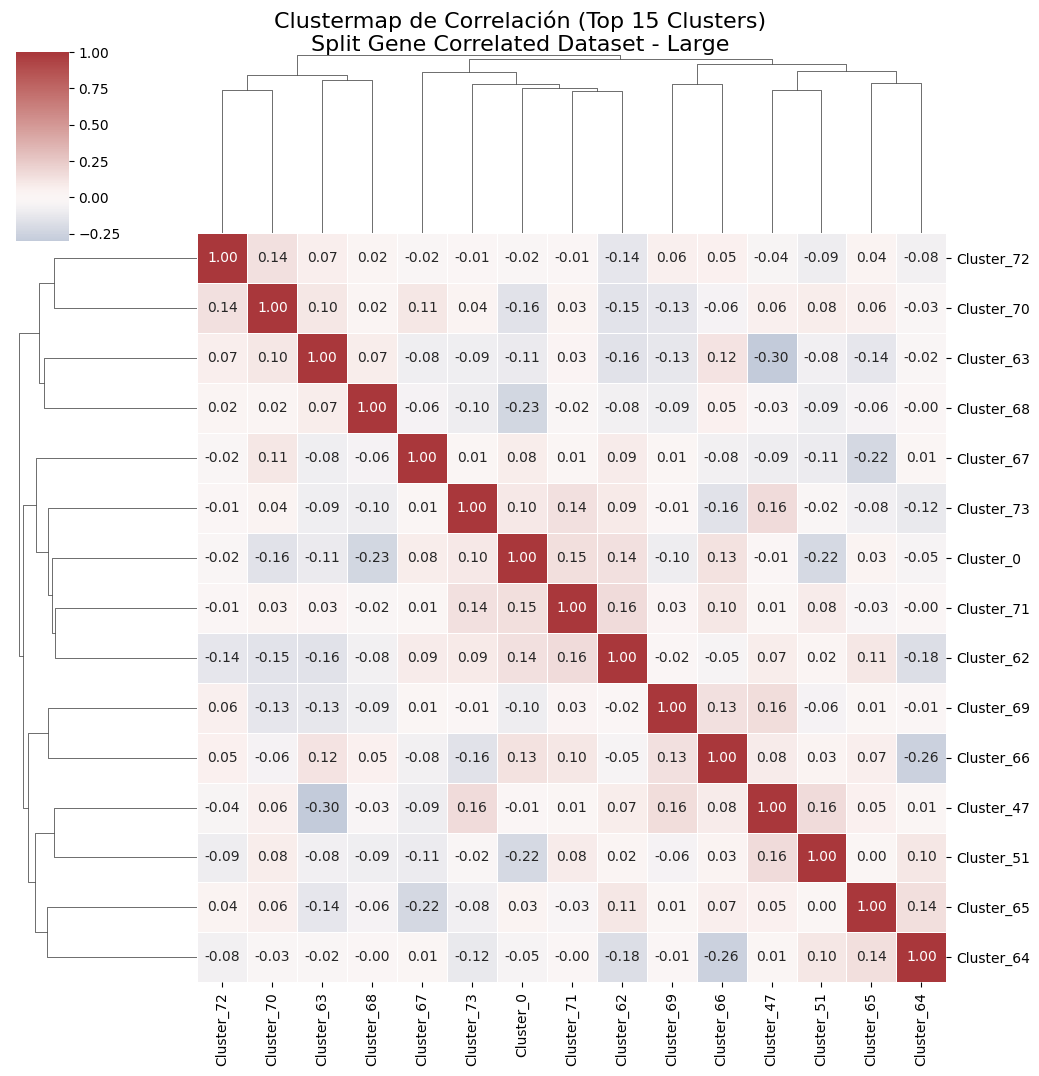

In [10]:
train_and_evaluate_cluster(df_gene, "Gene Dataset with Disease Effect - Large")
train_and_evaluate_cluster(df_minimal, "Minimal Effect Gene Dataset - Large")
train_and_evaluate_cluster(df_split, "Split Gene Correlated Dataset - Large")